In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scalecast --upgrade

In [ ]:
import warnings
import pickle # joblib
import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from itertools import cycle
from itertools import combinations
from collections import Counter
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# General settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore') # Supress Warnings 
%matplotlib inline

# time series
import holidays
from datetime import date
# from scalecast.Forecaster import Forecaster

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


data_dir = '/Data'

# Load Dataset

In [ ]:
def df_type_trans(df):
    df['Quote_dt'] = pd.to_datetime(df['Quote_dt'], format = '%Y-%m-%d')
    df['zip'] = df['zip'].astype('Int64').astype('object')
    df['Agent_cd'] = df['Agent_cd'].astype('Int64').astype('object')
    df['CAT_zone'] = df['CAT_zone'].astype('Int64')
    df['high_education_ind'] = df['high_education_ind'].astype('Int64')
    df['convert_ind'] = df['convert_ind'].astype('Int64')
    return df

def load_df(train_test_split=True, get_holiday=False):
    df = pd.read_csv(os.path.join(data_dir, 'analytical_df.csv'))
    df = df_type_trans(df)  # fix dtypes
    # create time based features
    df = df.assign(
        dayofweek = lambda x: x.Quote_dt.dt.dayofweek,
        month = lambda x: x.Quote_dt.dt.month,
        quarter = lambda x: x.Quote_dt.dt.quarter
    )
    if get_holiday:
        df['holiday'] = df['Quote_dt'].apply(lambda x: 0 if holidays.US().get(x) is None else 1)
    if train_test_split:
        train = df[lambda x: x.split == 'Train'].drop(['split'], 1)
        train['convert_ind'] = train['convert_ind'].astype('int')
        test = df[lambda x: x.split == 'Test'].drop(['split'], 1)
    return (
        train, test
    ) if train_test_split else df

def fill_missing():
    pass

# Get conversion rate
def get_conversion_rate(df, variables=['var1','var2'], pivot=False):
    # get num of convert and total num of policy
    var_count = df.groupby(variables)['convert_ind'].aggregate(['sum', 'count']).reset_index()
    # get conversion rate
    var_count['conversion_rate'] = var_count['sum'] / var_count['count']
    var_count = var_count.rename(columns={'sum':'num_converted','count':'total'})
    # create pivot table
    if (len(variables) != 1) & pivot:
        var_pivot = var_count.pivot(
            index=variables[0],
            columns=variables[1],
            values='conversion_rate'
            ).fillna(0)
    elif len(variables) == 1 & pivot:
        pivot = False
        print('Only one variable passed')
    return var_pivot if pivot else var_count

In [ ]:
train, test = load_df()
train.shape, test.shape

((79615, 28), (26679, 28))

**Find missing values**

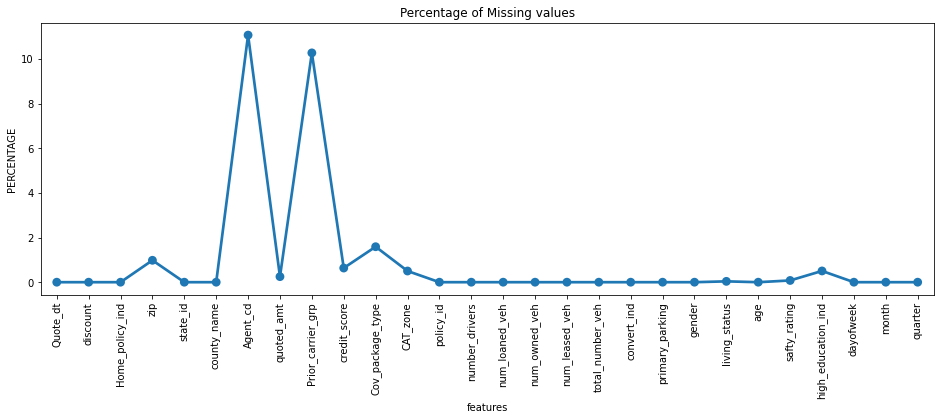

In [ ]:
missing = pd.DataFrame((train.isnull().sum())*100 / train.shape[0]).reset_index().rename(columns={'index': "features", 0: "pct_missing"})
plt.figure(figsize=(16,5))
fig = sns.pointplot(
    data=missing,
    x='features',
    y='pct_missing')
plt.xticks(rotation =90, fontsize =10)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

In [ ]:
train.head()

Quote_dt discount Home_policy_ind    zip state_id county_name  Agent_cd  \
0 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
1 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
3 2018-09-03       No               N  11548       NY      Nassau  32759856   
4 2018-09-03       No               N  11548       NY      Nassau  32759856   
6 2016-05-18       No               N  14622       NY      Monroe  15675431   

   quoted_amt Prior_carrier_grp  credit_score Cov_package_type  CAT_zone  \
0      5153.0         Carrier_1         613.0             High         2   
1      5153.0         Carrier_1         613.0             High         2   
3      3090.0         Carrier_4         631.0           Medium         2   
4      3090.0         Carrier_4         631.0           Medium         2   
6     14917.0         Carrier_3         602.0           Medium         4   

      policy_id  number_drivers  num_loaned_veh  num_owned_veh  \
0  policy_87209               2               1              2   
1  policy_87209               2               1              2   
3  policy_91413               2               1              2   
4  policy_91413               2               1              2   
6  policy_71845               2               0              1   

   num_leased_veh  total_number_veh  convert_ind primary_parking gender  \
0               0                 3            0   home/driveway      F   
1               0                 3            0   home/driveway      M   
3               1                 4            0         unknown      F   
4               1                 4            0         unknown      M   
6               2                 3            0         unknown      M   

  living_status  age  safty_rating  high_education_ind  dayofweek  month  \
0          rent   41          78.0                   1          2      1   
1          rent   58          70.0                   0          2      1   
3          rent   43          79.0                   1          0      9   
4          rent   55          61.0                   0          0      9   
6           own   74          94.0                   1          2      5   

   quarter  
0        1  
1        1  
3        3  
4        3  
6        2

# Data Exploration

In [ ]:
train_df = train.copy()

In [ ]:
bins = [train_df['age'].min(), 35, 55, train_df['age'].max()]
group_names = ['Junior', 'Middle Aged', 'Senior']
train_df['age_group'] = pd.cut(train_df['age'], bins, labels=group_names, include_lowest=True).astype('object')
# train_df.drop('age', axis=1, inplace=True)
train_df['age_group'].value_counts()

Junior         34657
Middle Aged    28773
Senior         16185
Name: age_group, dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79615 entries, 0 to 106293
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Quote_dt            79615 non-null  datetime64[ns]
 1   discount            79615 non-null  object        
 2   Home_policy_ind     79615 non-null  object        
 3   zip                 78834 non-null  object        
 4   state_id            79615 non-null  object        
 5   county_name         79615 non-null  object        
 6   Agent_cd            70805 non-null  object        
 7   quoted_amt          79417 non-null  float64       
 8   Prior_carrier_grp   71439 non-null  object        
 9   credit_score        79110 non-null  float64       
 10  Cov_package_type    78350 non-null  object        
 11  CAT_zone            79216 non-null  Int64         
 12  policy_id           79615 non-null  object        
 13  number_drivers      79615 non-null  int64    

## Univariate Analysis

In [ ]:
train_fill = pd.DataFrame()
for i, predictor in enumerate(train_df.drop(['Quote_dt', 'zip', 'county_name', 'Agent_cd', 'policy_id', 'quoted_amt', 'credit_score', 'safty_rating'], axis=1)):
    try:
        train_fill[predictor] = train_df[predictor].fillna('Missing')
    except:
        train_fill[predictor] = train_df[predictor].fillna(0)

In [ ]:
agg_df = train_fill.groupby('state_id')['convert_ind'].agg(['sum', 'count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
agg_df

state_id   sum  count  cov_rate
0       AL    60   1715  0.034985
1       CT   342   3912  0.087423
2       FL  1795  19319  0.092914
3       GA   289   4622  0.062527
4       MN   399   4378  0.091138
5       NJ  1825  15798  0.115521
6       NY  3013  25190  0.119611
7       WI   260   4681  0.055544

['0', '1', '2', '3', '4', '5']


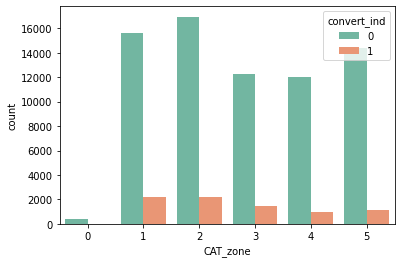

In [ ]:
ax1 = sns.countplot(
    data=train_fill, x='CAT_zone', hue='convert_ind',
    palette='Set2')
print([t.get_text() for t in ax1.get_xticklabels()])

In [ ]:
get_conversion_rate(train_fill, ['CAT_zone']).set_index('CAT_zone')

num_converted  total  conversion_rate
CAT_zone                                       
0                    30    399         0.075188
1                  2173  17801         0.122072
2                  2240  19188         0.116740
3                  1448  13694         0.105740
4                   972  13027         0.074614
5                  1120  15506         0.072230

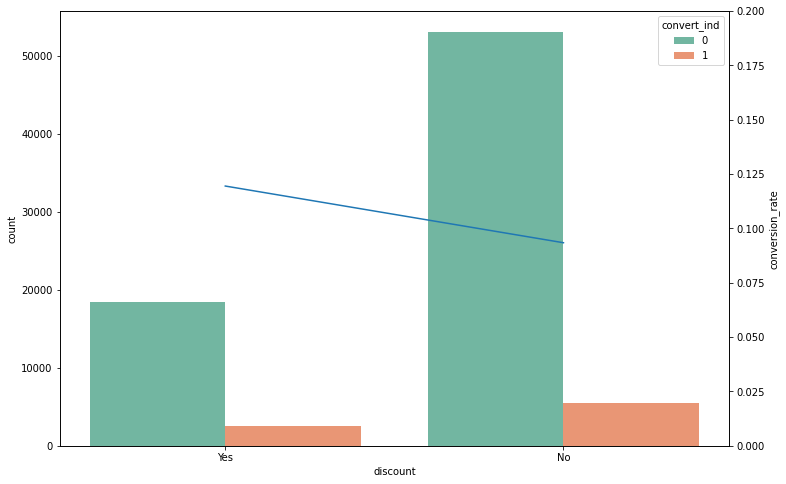

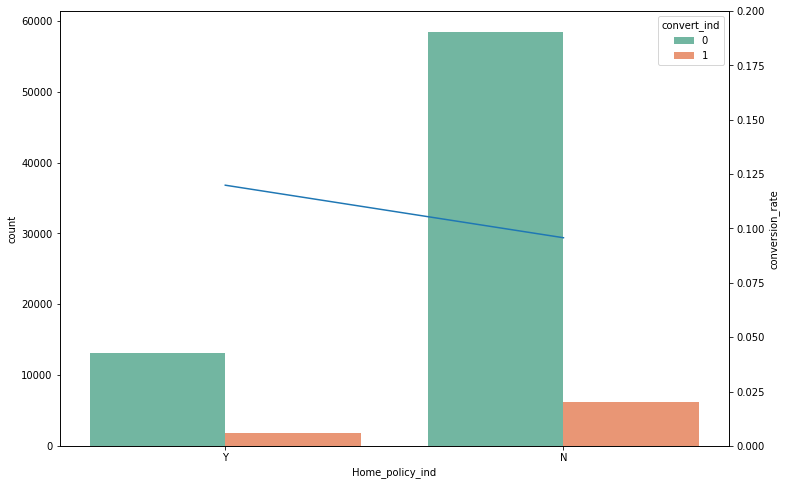

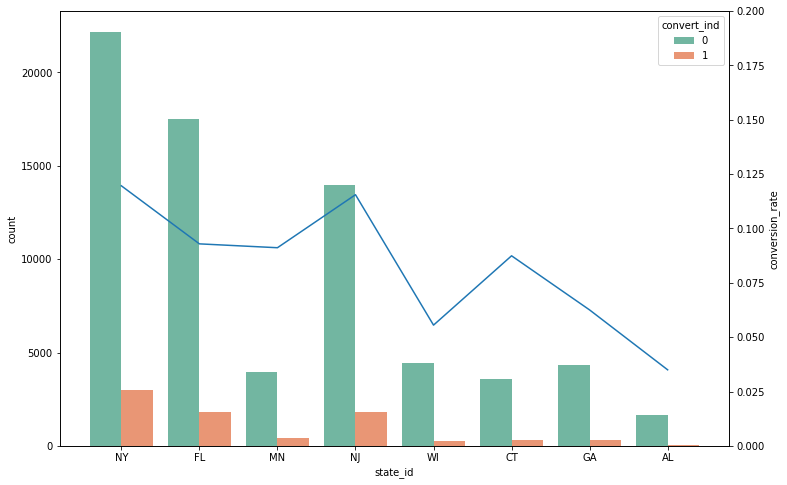

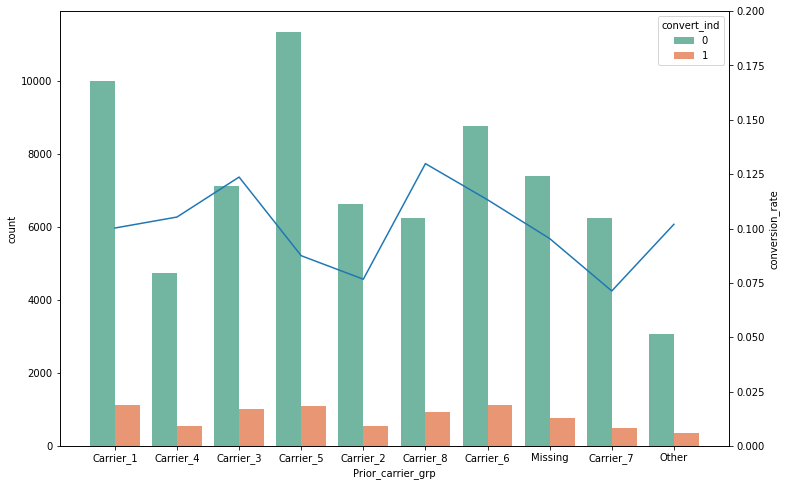

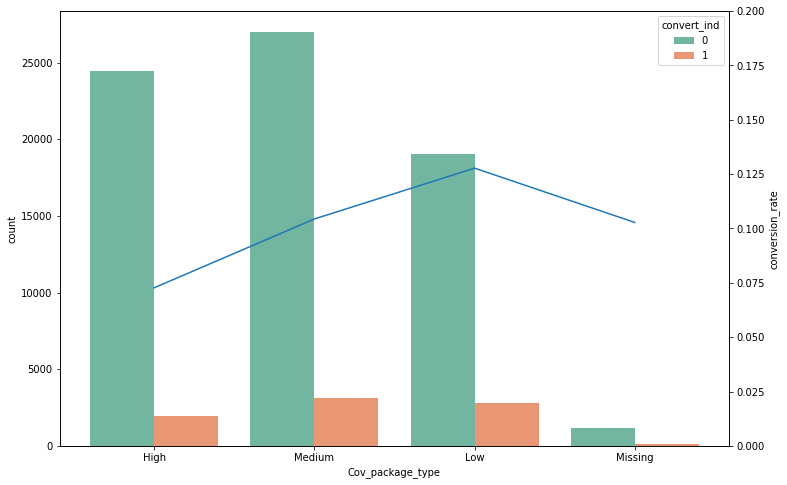

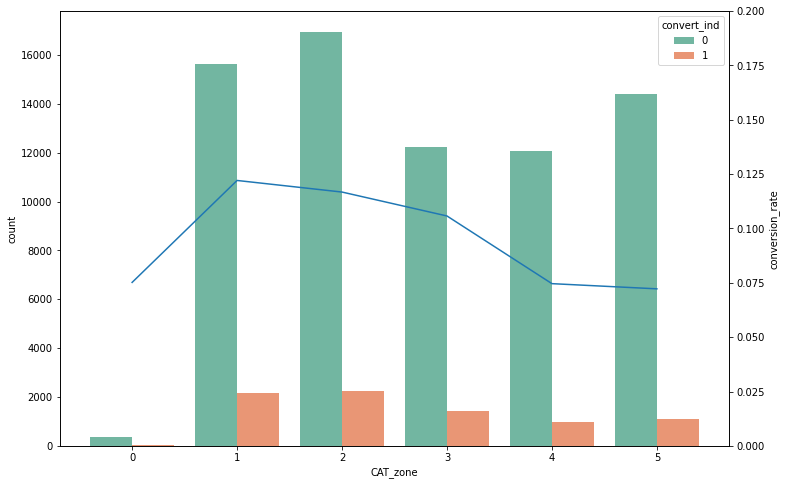

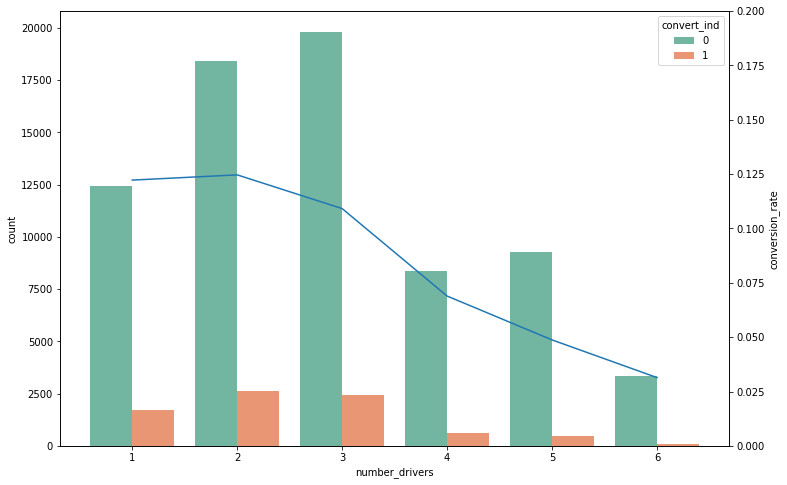

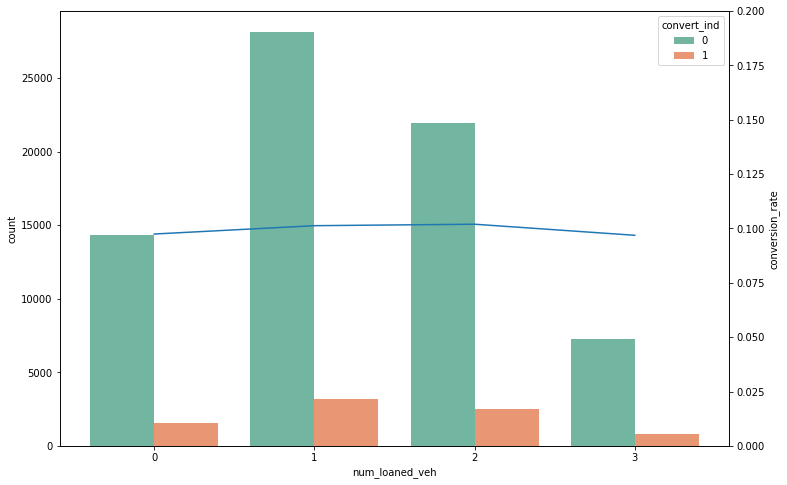

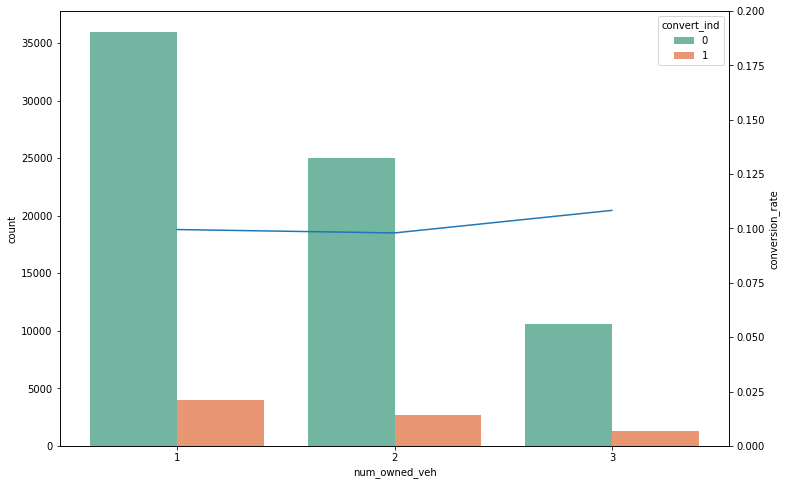

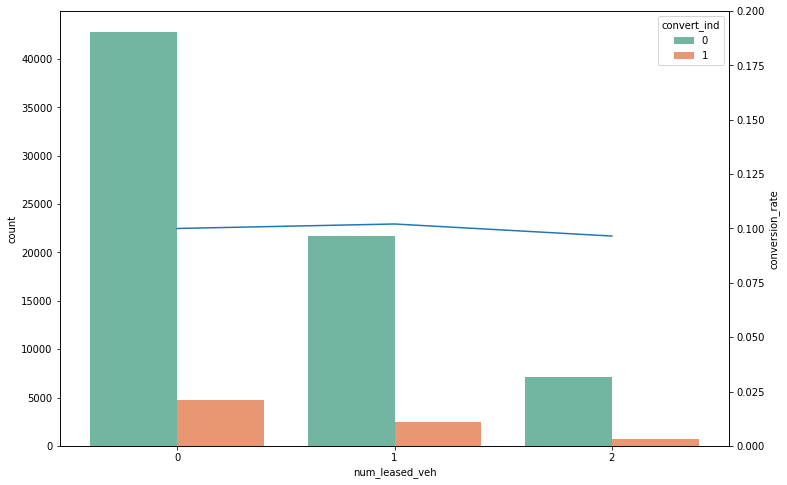

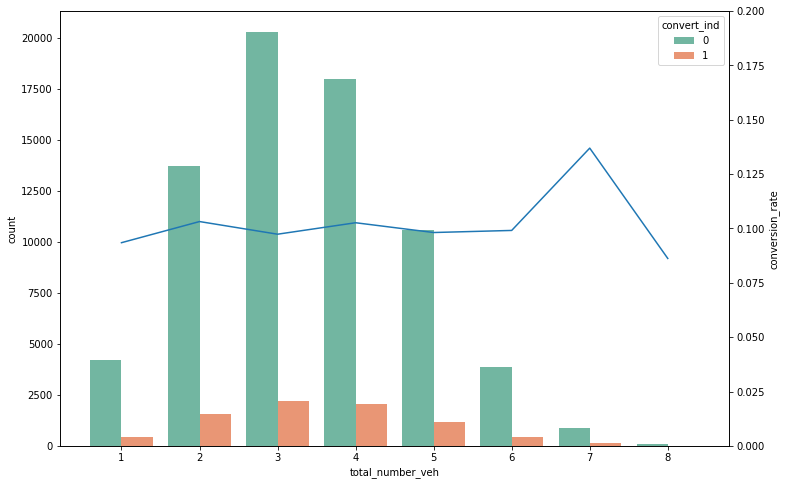

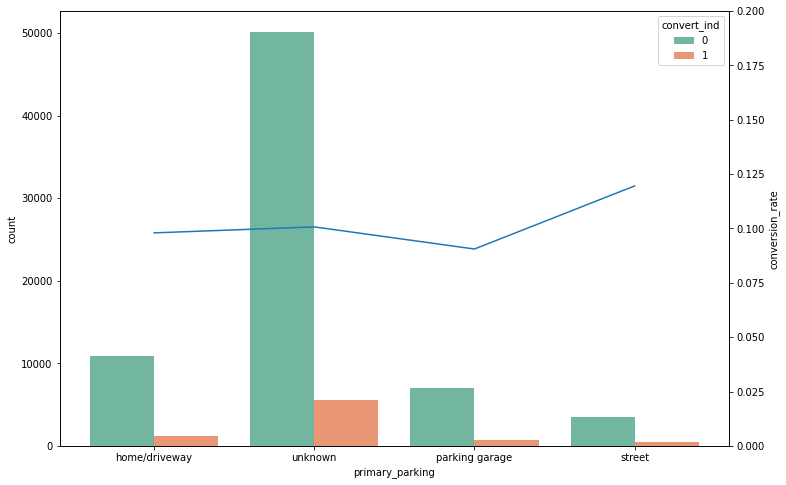

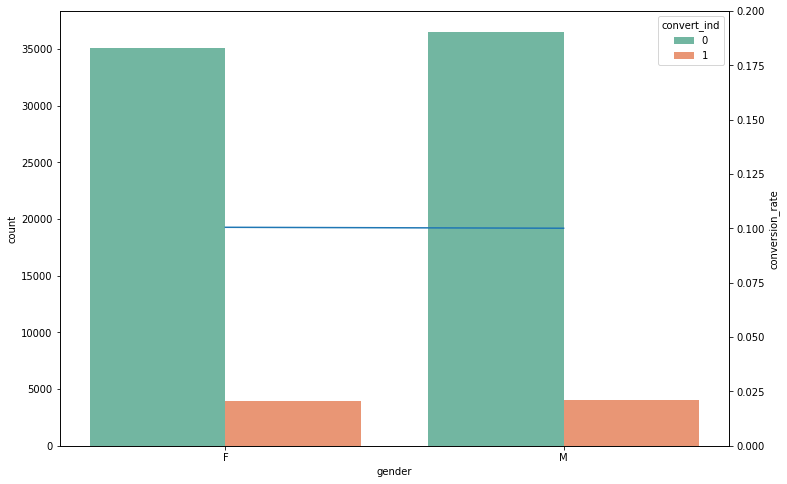

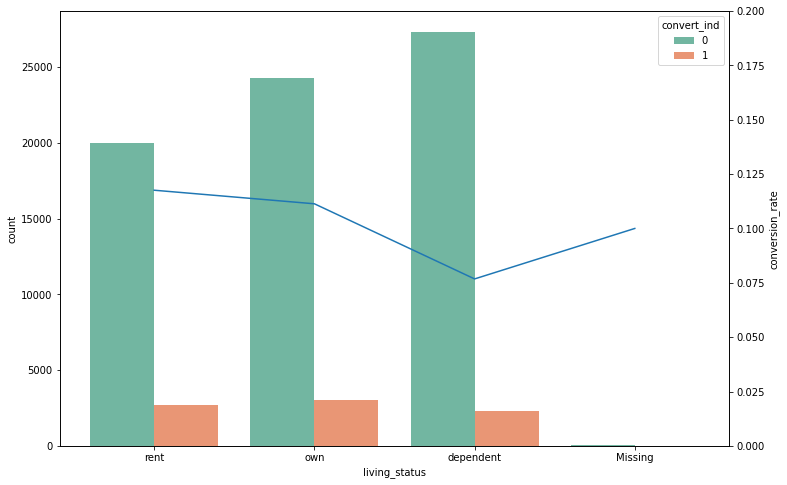

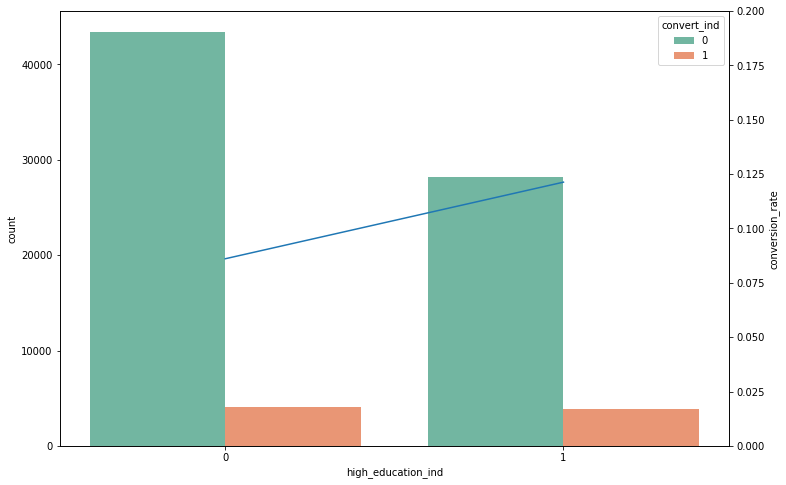

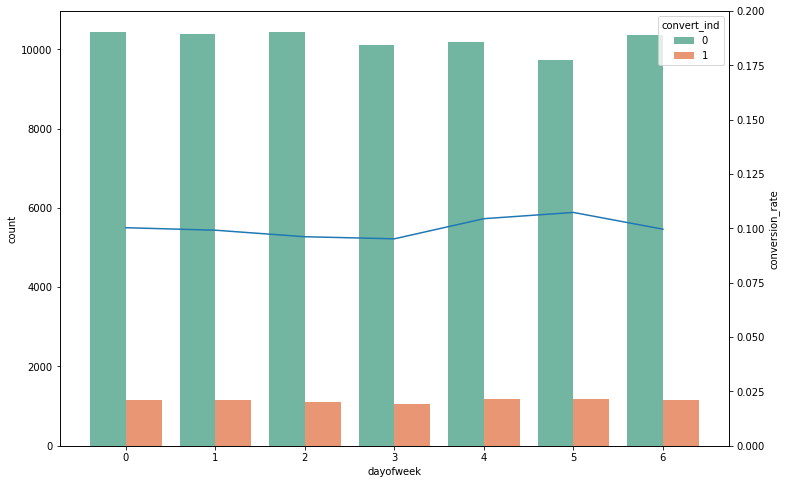

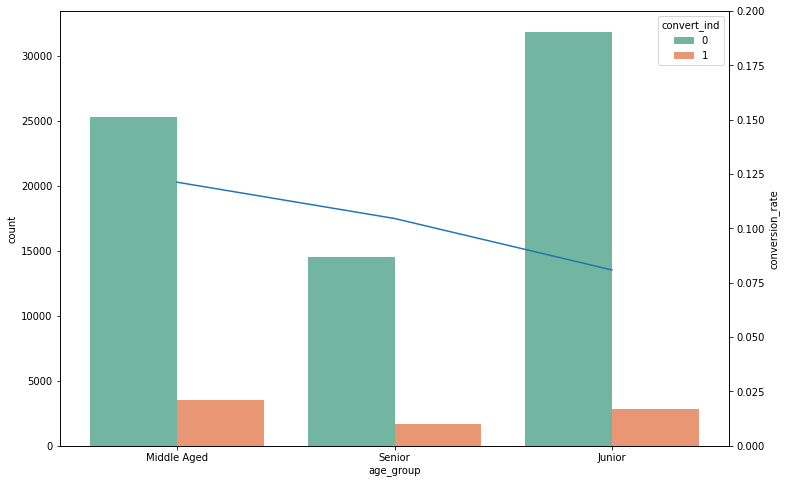

In [ ]:
int_cat_list = ['number_drivers', 'num_owned_veh', 'total_number_veh', 'month', 'quarter']  # these variables start with 1, will cause shift to right when plot
for i, predictor in enumerate(train_fill.drop(['month', 'quarter', 'convert_ind'], axis=1)):
    # agg_df = train_fill.groupby(predictor)['convert_ind'].agg(['sum', 'count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
    plt.figure(i, figsize=(12,8))
    ax1 = sns.countplot(
        data=train_fill, x=predictor, hue='convert_ind',
        palette='Set2')
    # Plot conversion rate with dual axis
    ax2 = ax1.twinx()
    cov = get_conversion_rate(train_fill, [predictor])
    if predictor in int_cat_list:
        cov[predictor] = cov[predictor]-1
    elif predictor not in ['CAT_zone', 'num_leased_veh', 'num_loaned_veh', 'high_education_ind', 'dayofweek']:
        cov = cov.set_index(predictor).loc[[t.get_text() for t in ax1.get_xticklabels()],]
    sns.lineplot(
        data=cov, x=predictor, y='conversion_rate',
        ax=ax2)
    ax2.set_ylim(0, 0.2)
plt.show()

From the bar plots:
- Customers who park at home or driveway compared to garage and street are more likely to convert .
- NY and NJ have relatively high conversion. While MN has fewer number of quotes, the conversion rate remains relatively high.
- Most customers demand Low coverage, while they are more likely to convert.
- Catastrophe risk zone 1 and 2 are more likely to convert. We are not sure about the ranking.
- The larger family size, the less they would convert.
- Customers who park on the street are more likely to convert.
- With 7 cars, this group of customers has higher conversion. However, they are not a large portion of the whole population.
- Customers who recieve high education are more likely to convert.
- People aged from 35 to 55 compose a larger group in the whole population, and they are more likely to purchase a care insurance.

- Customers who have house insurance with the company were also given discounts on their car insurance.

In [ ]:
pd.crosstab(train_fill['Home_policy_ind'], train_fill['discount'])

discount            No    Yes
Home_policy_ind              
N                58604   6056
Y                    0  14955

**Get dummy variables**

In [ ]:
train_df.head()

Quote_dt  discount  Home_policy_ind  zip  state_id  county_name  Agent_cd  \
0 2015-01-28         1                1  371         6           10        67   
1 2015-01-28         1                1  371         6           10        67   
3 2018-09-03         0                0  536         6           67       387   
4 2018-09-03         0                0  536         6           67       387   
6 2016-05-18         0                0  685         6           63        61   

   quoted_amt  Prior_carrier_grp  credit_score  Cov_package_type  CAT_zone  \
0      5153.0                  0         613.0                 0         2   
1      5153.0                  0         613.0                 0         2   
3      3090.0                  3         631.0                 2         2   
4      3090.0                  3         631.0                 2         2   
6     14917.0                  2         602.0                 2         4   

   policy_id  number_drivers  num_loaned_veh  num_owned_veh  num_leased_veh  \
0      31315               2               1              2               0   
1      31315               2               1              2               0   
3      32951               2               1              2               1   
4      32951               2               1              2               1   
6      25394               2               0              1               2   

   total_number_veh  convert_ind  primary_parking  gender  living_status  \
0                 3            0                0       0              2   
1                 3            0                0       1              2   
3                 4            0                3       0              2   
4                 4            0                3       1              2   
6                 3            0                3       1              1   

   safty_rating  high_education_ind  dayofweek  month  quarter  age_group  
0          78.0                   1          2      1        1          1  
1          70.0                   0          2      1        1          2  
3          79.0                   1          0      9        3          1  
4          61.0                   0          0      9        3          1  
6          94.0                   1          2      5        2          2

In [ ]:
train_dummies = pd.get_dummies(train_df.drop(['Quote_dt', 'zip', 'county_name', 'Agent_cd', 'policy_id'], axis=1))
train_dummies.head()

quoted_amt  credit_score  CAT_zone  number_drivers  num_loaned_veh  \
0      5153.0         613.0         2               2               1   
1      5153.0         613.0         2               2               1   
3      3090.0         631.0         2               2               1   
4      3090.0         631.0         2               2               1   
6     14917.0         602.0         4               2               0   

   num_owned_veh  num_leased_veh  total_number_veh  convert_ind  safty_rating  \
0              2               0                 3            0          78.0   
1              2               0                 3            0          70.0   
3              2               1                 4            0          79.0   
4              2               1                 4            0          61.0   
6              1               2                 3            0          94.0   

   high_education_ind  dayofweek  month  quarter  discount_No  discount_Yes  \
0                   1          2      1        1            0             1   
1                   0          2      1        1            0             1   
3                   1          0      9        3            1             0   
4                   0          0      9        3            1             0   
6                   1          2      5        2            1             0   

   Home_policy_ind_N  Home_policy_ind_Y  state_id_AL  state_id_CT  \
0                  0                  1            0            0   
1                  0                  1            0            0   
3                  1                  0            0            0   
4                  1                  0            0            0   
6                  1                  0            0            0   

   state_id_FL  state_id_GA  state_id_MN  state_id_NJ  state_id_NY  \
0            0            0            0            0            1   
1            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   
6            0            0            0            0            1   

   state_id_WI  Prior_carrier_grp_Carrier_1  Prior_carrier_grp_Carrier_2  \
0            0                            1                            0   
1            0                            1                            0   
3            0                            0                            0   
4            0                            0                            0   
6            0                            0                            0   

   Prior_carrier_grp_Carrier_3  Prior_carrier_grp_Carrier_4  \
0                            0                            0   
1                            0                            0   
3                            0                            1   
4                            0                            1   
6                            1                            0   

   Prior_carrier_grp_Carrier_5  Prior_carrier_grp_Carrier_6  \
0                            0                            0   
1                            0                            0   
3                            0                            0   
4                            0                            0   
6                            0                            0   

   Prior_carrier_grp_Carrier_7  Prior_carrier_grp_Carrier_8  \
0                            0                            0   
1                            0                            0   
3                            0                            0   
4                            0                            0   
6                            0                            0   

   Prior_carrier_grp_Other  Cov_package_type_High  Cov_package_type_Low  \
0                        0                      1                     0   
1                     

**Insights:**
- Conversion is related with high credit score, customers recieved high education, low coverage, etc.
- Conversion is negatively affected by larger famiy size, higher quoted amount, catastrophe risk level, and coverage.

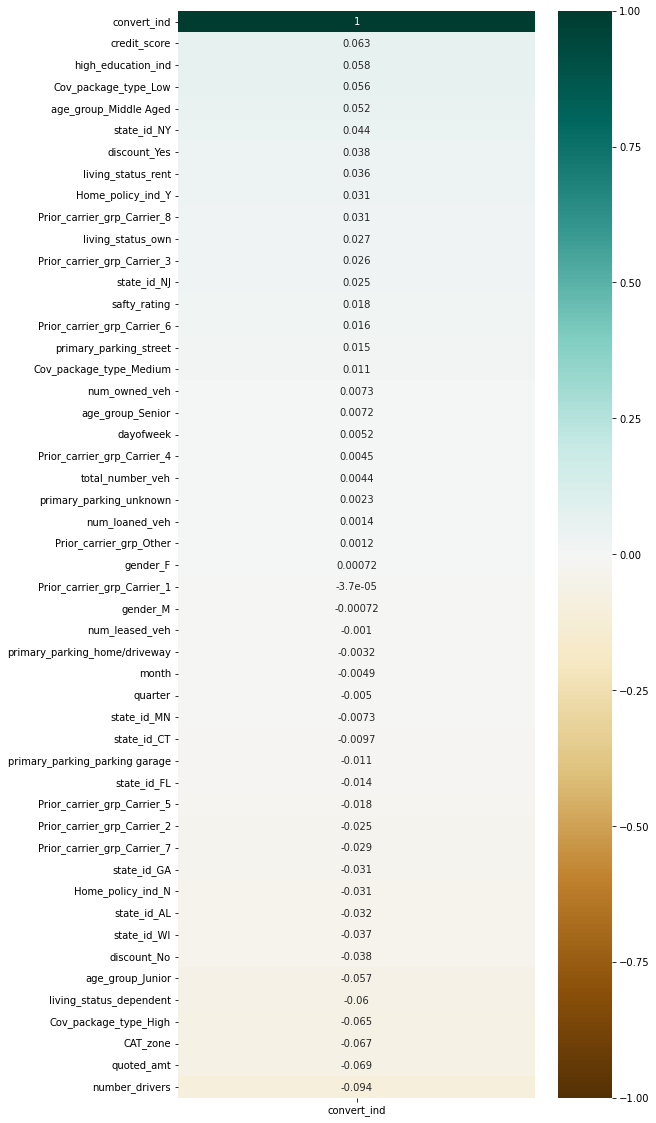

In [ ]:
plt.figure(figsize=(8,20))
fig = sns.heatmap(
    train_dummies.corr()[['convert_ind']].sort_values(by='convert_ind', ascending = False), 
    vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

Use density plots to discover relationships between numeric variables and target variable.

In [ ]:
train.select_dtypes(include=['float']).isna().sum()

quoted_amt      198
credit_score    505
safty_rating     62
dtype: int64

In [ ]:
train_fill_num = train.select_dtypes(include=['float'])
train_fill_num = train_fill_num.fillna(train_fill_num.mean()) # fill with mean
train_fill_num['convert_ind'] = train['convert_ind']

quoted_amt  credit_score  safty_rating  convert_ind
0      5153.0         613.0          78.0            0
1      5153.0         613.0          70.0            0
3      3090.0         631.0          79.0            0
4      3090.0         631.0          61.0            0
6     14917.0         602.0          94.0            0

- Observed skewness in quoted amount and safety rating.
- Most customers tend to have lower quoted amount.

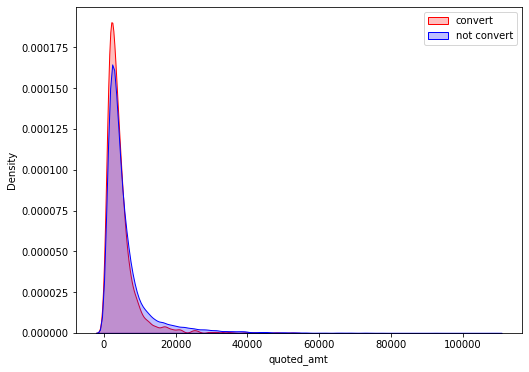

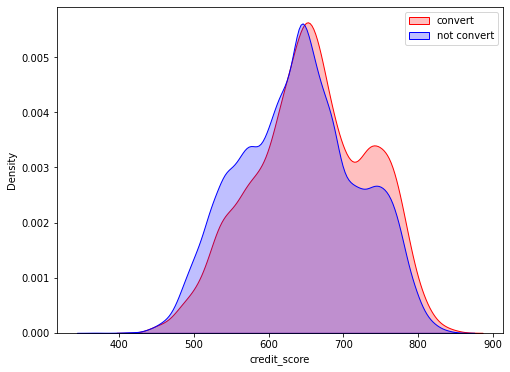

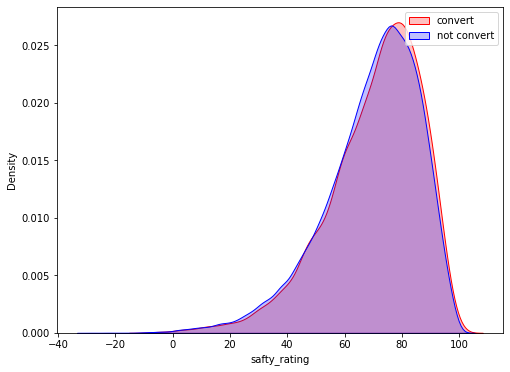

In [ ]:
for i, predictor in enumerate(train_fill_num.drop('convert_ind', axis=1)):
    plt.figure(i, figsize=(8,6))
    convert = train_fill_num[lambda x: x.convert_ind == 1][[predictor]]
    not_convert = train_fill_num[lambda x: x.convert_ind == 0][[predictor]]
    ax = sns.kdeplot(
        data=convert, x=predictor,
        color="Red", fill=True)
    sns.kdeplot(
        data=not_convert, x=predictor,
        color="Blue", fill=True,
        ax=ax)
    ax.legend(['convert', 'not convert'], loc='upper right')
plt.show()

## Multivariate Analysis

In [ ]:
def df_convert_dtypes(df, convert_from, convert_to):
    df = df.copy()
    cols = df.select_dtypes(include=[convert_from]).columns  # select the original columns
    for col in cols:
        df[col] = df[col].astype(convert_to)  # convert to new type
    return df
train_cat = df_convert_dtypes(train_df, "object", 'category')

In [ ]:
for cat_col in train_cat.select_dtypes(include=['category']).columns:
    train_cat[cat_col] = train_cat[cat_col].cat.codes
train_cat.head()

Quote_dt  discount  Home_policy_ind  zip  state_id  county_name  Agent_cd  \
0 2015-01-28         1                1  371         6           10        67   
1 2015-01-28         1                1  371         6           10        67   
3 2018-09-03         0                0  536         6           67       387   
4 2018-09-03         0                0  536         6           67       387   
6 2016-05-18         0                0  685         6           63        61   

   quoted_amt  Prior_carrier_grp  credit_score  Cov_package_type  CAT_zone  \
0      5153.0                  0         613.0                 0         2   
1      5153.0                  0         613.0                 0         2   
3      3090.0                  3         631.0                 2         2   
4      3090.0                  3         631.0                 2         2   
6     14917.0                  2         602.0                 2         4   

   policy_id  number_drivers  num_loaned_veh  num_owned_veh  num_leased_veh  \
0      31315               2               1              2               0   
1      31315               2               1              2               0   
3      32951               2               1              2               1   
4      32951               2               1              2               1   
6      25394               2               0              1               2   

   total_number_veh  convert_ind  primary_parking  gender  living_status  \
0                 3            0                0       0              2   
1                 3            0                0       1              2   
3                 4            0                3       0              2   
4                 4            0                3       1              2   
6                 3            0                3       1              1   

   safty_rating  high_education_ind  dayofweek  month  quarter  age_group  
0          78.0                   1          2      1        1          1  
1          70.0                   0          2      1        1          2  
3          79.0                   1          0      9        3          1  
4          61.0                   0          0      9        3          1  
6          94.0                   1          2      5        2          2

**Insights from heatmap:**

- Customer's age has high positive correlation with living status and education recieved. Additionally, it has negative correlation with family size. 
- Customers who were given discounts also have existing home insurance policy with Peace of Mind
- Customers' credit score would affect the quota negatively.
- The customers are prone to purchase cars by loans.

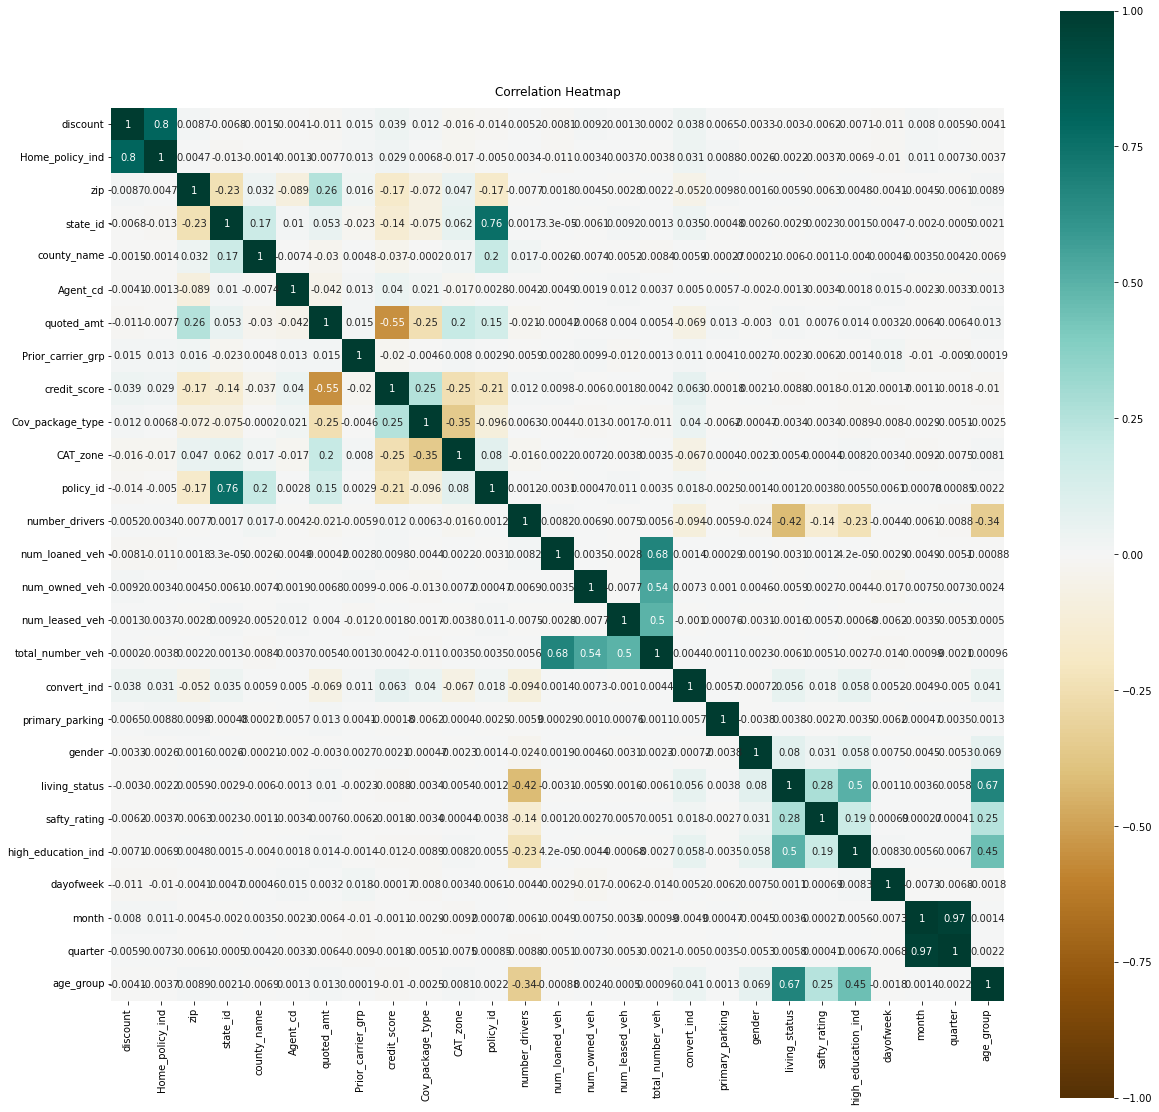

In [ ]:
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(
    train_cat.corr(method='pearson'), 
    annot=True, vmin=-1, vmax=1, square=True, cmap="BrBG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

# Time Series

- How does conversion rates change over the years?
- Conversion rates have seasonal trend?

In [ ]:
policy = train.groupby('policy_id', as_index= False).first()
policy.head(3)

policy_id   Quote_dt discount Home_policy_ind      zip state_id  \
0    policy_100 2017-06-11       No               N  35209.0       AL   
1   policy_1000 2018-03-24       No               N  35064.0       AL   
2  policy_10002 2018-07-04       No               N  32206.0       FL   

  county_name    Agent_cd  quoted_amt Prior_carrier_grp  ...  convert_ind  \
0   Jefferson  57246922.0     10698.0         Carrier_3  ...          0.0   
1   Jefferson  89956217.0     43811.0         Carrier_3  ...          0.0   
2       Duval  58906466.0      6624.0         Carrier_7  ...          0.0   

  primary_parking  gender  living_status  age  safty_rating  \
0   home/driveway       F            own   50          75.0   
1          street       M           rent   35          50.0   
2         unknown       M           rent   49          90.0   

   high_education_ind  dayofweek  month quarter  
0                   1          6      6       2  
1                   1          5      3       1  
2                   1          2      7       3  

[3 rows x 28 columns]

In [ ]:
ts_trend = policy.set_index('Quote_dt')['convert_ind'].resample('Q').apply(['sum','count']).assign(cov_rate = lambda x: x['sum']/x['count'])
ts_trend

sum  count  cov_rate
Quote_dt                          
2015-03-31  312.0   2628  0.118721
2015-06-30  328.0   2643  0.124101
2015-09-30  332.0   2737  0.121301
2015-12-31  344.0   2872  0.119777
2016-03-31  311.0   3000  0.103667
2016-06-30  356.0   3033  0.117376
2016-09-30  349.0   3000  0.116333
2016-12-31  340.0   3112  0.109254
2017-03-31  136.0   1282  0.106084
2017-06-30  154.0   1292  0.119195
2017-09-30  118.0   1347  0.087602
2017-12-31  153.0   1347  0.113586
2018-03-31  236.0   2138  0.110384
2018-06-30  215.0   2072  0.103764
2018-09-30  217.0   2141  0.101355
2018-12-31  219.0   2227  0.098339

In [ ]:
fig = px.bar(
    ts_trend,
    x=ts_trend.index,
    y='count',
    color='cov_rate',
    color_continuous_scale='ice',
    labels={
        'Quote_dt': 'Quote issued date',
        'count': 'Num of quotes',
        'cov_rate': 'Conversion'
    },
    title='Quote Trends (by Quarter)'
)
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,})
fig.show()

## Seasonal test

In [ ]:
ts_seasonal = policy.set_index('Quote_dt')['convert_ind'].resample('M').apply(['sum','count']).assign(cov_rate = lambda x: x['sum']/x['count'])
fig = px.line(
    ts_seasonal,
    x=ts_seasonal.index,
    y='cov_rate',
    labels={
        'Quote_dt': 'Quote issued date',
        'cov_rate': 'Conversion'
    })
# remove background
# fig.update_layout({
#     # 'plot_bgcolor': 'rgba(0, 0, 0, 0)', # remove bg in plot area
#     # 'paper_bgcolor': 'rgba(0, 0, 0, 0)', # remove bg in figure area
# })
fig.show()

In [ ]:
sns.set(rc={'figure.figsize':(25,8)})

In [ ]:
f = Forecaster(
    y=ts_seasonal.cov_rate,
    current_dates=ts_seasonal.index)

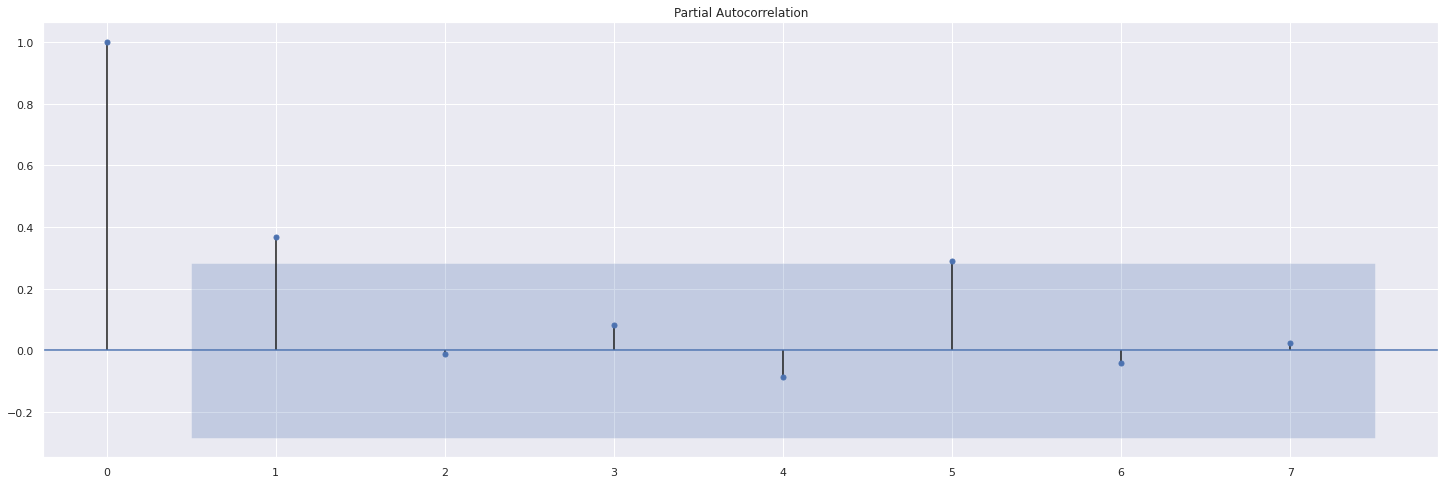

In [ ]:
f.plot_pacf(lags=7)
plt.show()

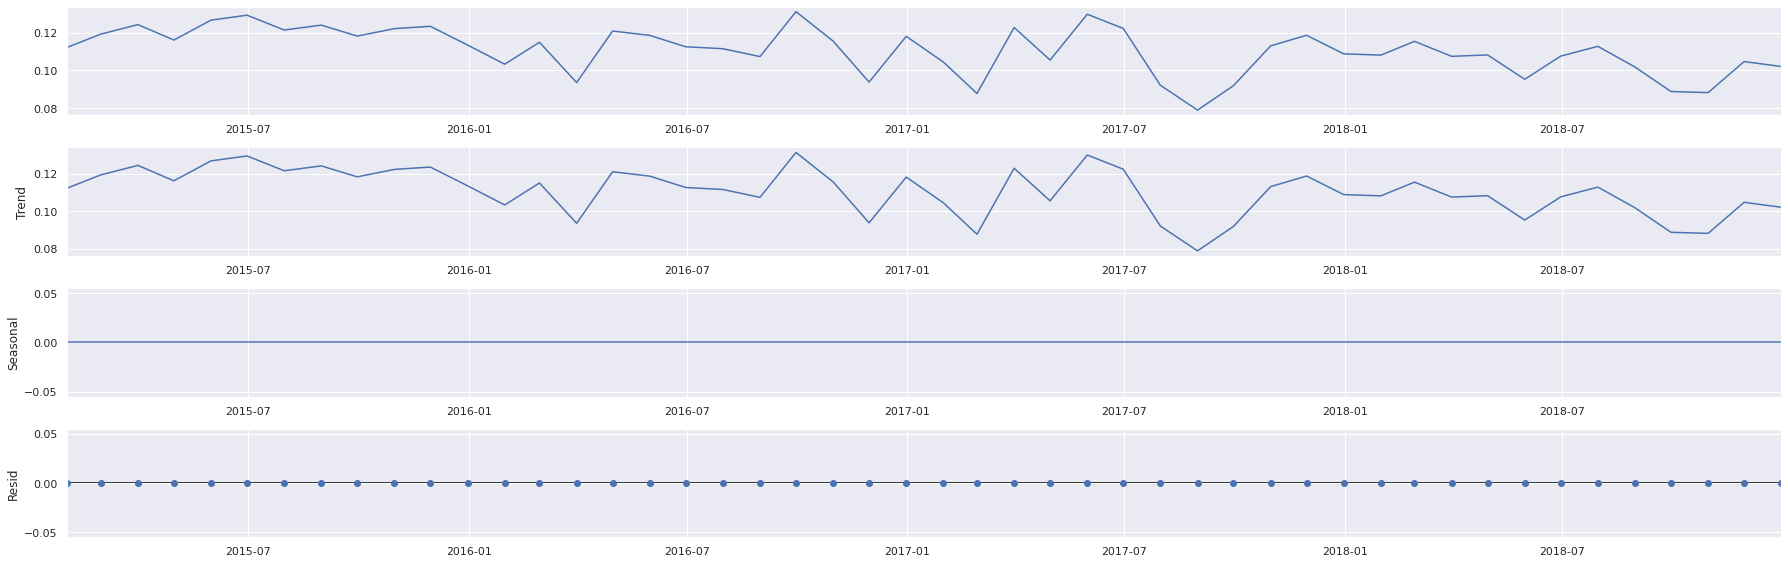

In [ ]:
f.seasonal_decompose(model='additive', extrapolate_trend='freq', period=1).plot()
plt.show()

In [ ]:
stat, p, _, _, _, _ = f.adf_test(full_res=True)
print(stat,p)

-4.557968642034878 0.0001542814963068178


# Customer Profile

In [ ]:
train_fill = pd.DataFrame()

num_var = train_df.select_dtypes(include=['float']).columns
for i, predictor in enumerate(train_df.drop(columns=num_var)):
    try:
        train_fill[predictor] = train_df[predictor].fillna('Missing')
    except:
        train_fill[predictor] = train_df[predictor].fillna(0)
for i, predictor in enumerate(train_df[num_var]):
    train_fill[predictor] = train_df[predictor].fillna(train_df[predictor].mean())


## Assumptions

- Will giving discount improve conversion?
- How does quoted_amt related to cars, safety rating, etc. (bins)
- How does family size affect conversion?
- Does number of cars per person affect conversion?

In [ ]:
policy = train_fill.groupby('policy_id', as_index= False).first()
policy.head()

policy_id   Quote_dt discount Home_policy_ind    zip state_id  \
0    policy_100 2017-06-11       No               N  35209       AL   
1   policy_1000 2018-03-24       No               N  35064       AL   
2  policy_10002 2018-07-04       No               N  32206       FL   
3  policy_10004 2015-10-21       No               N  33990       FL   
4  policy_10005 2016-10-05       No               N  33760       FL   

  county_name  Agent_cd Prior_carrier_grp Cov_package_type  CAT_zone  \
0   Jefferson  57246922         Carrier_3             High         3   
1   Jefferson  89956217         Carrier_3             High         5   
2       Duval  58906466         Carrier_7             High         2   
3         Lee  79291466             Other             High         2   
4    Pinellas  13181819         Carrier_2              Low         1   

   number_drivers  num_loaned_veh  num_owned_veh  num_leased_veh  \
0               2               0              1               0   
1               1               2              1               0   
2               5               1              2               0   
3               5               1              2               0   
4               3               0              2               1   

   total_number_veh  convert_ind primary_parking gender living_status  \
0                 1            0   home/driveway      F           own   
1                 3            0          street      M          rent   
2                 3            0         unknown      M          rent   
3                 3            0         unknown      M           own   
4                 3            0         unknown      M           own   

   high_education_ind  dayofweek  month  quarter    age_group  quoted_amt  \
0                   1          6      6        2  Middle Aged     10698.0   
1                   1          5      3        1       Junior     43811.0   
2                   1          2      7        3  Middle Aged      6624.0   
3                   0          2     10        4       Junior      2511.0   
4                   0          2     10        4       Senior      2362.0   

   credit_score  safty_rating  
0         582.0          75.0  
1         560.0          50.0  
2         557.0          90.0  
3         585.0          79.0  
4         641.0          72.0

- Will giving discount improve conversion?

Based on hypothesis test, we observed statistically significant difference between the results from giving discounts and not giving discounts.

**Give discounts would help improve conversion.**

In [ ]:
discount_df = pd.merge(
    policy[policy['convert_ind']==0].groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Not converted"}),
    policy[policy['convert_ind']==1].groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Converted"}),
    on='discount'
)
discount_df

discount  Not converted  Converted
0       No          24362       2818
1      Yes           8389       1302

In [ ]:
fig = px.bar(
    discount_df, x=['Not converted', 'Converted'], y='discount',
     orientation ='h')
fig.show()

In [ ]:
import statsmodels.stats.proportion as sp
n_control = discount_df.sum(1)[0]
n_test = discount_df.sum(1)[1]
convert_control = discount_df.query('discount=="No"')['Converted'].values[0]
convert_test = discount_df.query('discount=="Yes"')['Converted'].values[0]

z_score, p_value = sp.proportions_ztest([convert_control, convert_test], [n_control, n_test], alternative='smaller')
print('z score:', z_score, '，p-value:', p_value)

z score: -8.228803866823847 ，p-value: 9.454604795145621e-17


In [ ]:
fig = px.pie(discount_df.assign(sample_size = lambda x: x.sum(1)),
             values='sample_size', names='discount')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    title='Sample Proportions',
    legend_title="Discount"
)
fig.show()

We need to track the result of giving discount monthly. **Starting from mid 2017, giving discount did not seem to improve conversion.**

In [ ]:
discount_No = policy.query('discount=="No"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
discount_Yes = policy.query('discount=="Yes"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=discount_No["Quote_dt"], y=discount_No["cov_rate"],
                    mode='lines', name='No'))
fig.add_trace(go.Scatter(x=discount_Yes["Quote_dt"], y=discount_Yes["cov_rate"],
                    mode='lines', name='Yes'))
fig.update_layout(
    title='Discount & Conversion Rate',
    xaxis_title='Time',
    yaxis_title='Conversion Rate',
    legend_title="Discount"
)
fig.show()

Conduct hypothesis test on data after 2017

In [ ]:
discount_df_2017 = pd.merge(
    policy.query('(Quote_dt>="2017-07-01") & (convert_ind==0)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Not converted"}),
    policy.query('(Quote_dt>="2017-07-01") & (convert_ind==1)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Converted"}),
    on='discount'
)
discount_df_2017

discount  Not converted  Converted
0       No           7426        851
1      Yes           2688        307

In [ ]:
n_control = discount_df_2017.sum(1)[0]
n_test = discount_df_2017.sum(1)[1]
convert_control = discount_df_2017.query('discount=="No"')['Converted'].values[0]
convert_test = discount_df_2017.query('discount=="Yes"')['Converted'].values[0]

z_score, p_value = sp.proportions_ztest([convert_control, convert_test], [n_control, n_test], alternative='smaller')
print('z score:', z_score, '，p-value:', p_value)

z score: 0.04801521185530773 ，p-value: 0.5191479403587317


- How does quoted_amt related to cars, safety rating, etc.

We did not observe significant relationship among quoted amount, age, and safety rating.

In [ ]:
vehicles = pd.read_csv(os.path.join(data_dir, 'vehicles.csv'), index_col=0).reset_index(drop=True)
vehicles.head()

policy_id  car_no ownership_type  color  age               make_model
0  policy_74571       1         leased  other  4.0            BMW : R1200CL
1  policy_74571       2          owned   blue  3.0               ACURA : TL
2   policy_1998       1          owned   gray  7.0              BMW : 750LI
3  policy_28085       1          owned   gray  4.0  MERCEDES-BENZ : G55 AMG
4  policy_64282       1          owned  black  4.0            BMW : 550I GT

In [ ]:
col_list = train.columns.to_list()
func_list = ["first" for i in range(len(col_list))]
agg_dict = dict(zip(col_list,func_list))
agg_dict['age'] = 'mean'
agg_dict['safty_rating'] = 'mean'

In [ ]:
quoted_amt_df = train.groupby('policy_id', as_index= False).agg(agg_dict)
quoted_amt_df.head()

Quote_dt discount Home_policy_ind      zip state_id county_name  \
0 2017-06-11       No               N  35209.0       AL   Jefferson   
1 2018-03-24       No               N  35064.0       AL   Jefferson   
2 2018-07-04       No               N  32206.0       FL       Duval   
3 2015-10-21       No               N  33990.0       FL         Lee   
4 2016-10-05       No               N  33760.0       FL    Pinellas   

     Agent_cd  quoted_amt Prior_carrier_grp  credit_score Cov_package_type  \
0  57246922.0     10698.0         Carrier_3         582.0             High   
1  89956217.0     43811.0         Carrier_3         560.0             High   
2  58906466.0      6624.0         Carrier_7         557.0             High   
3  79291466.0      2511.0             Other         585.0             High   
4  13181819.0      2362.0         Carrier_2         641.0              Low   

   CAT_zone     policy_id  number_drivers  num_loaned_veh  num_owned_veh  \
0         3    policy_100               2               0              1   
1         5   policy_1000               1               2              1   
2         2  policy_10002               5               1              2   
3         2  policy_10004               5               1              2   
4         1  policy_10005               3               0              2   

   num_leased_veh  total_number_veh  convert_ind primary_parking gender  \
0               0                 1            0   home/driveway      F   
1               0                 3            0          street      M   
2               0                 3            0         unknown      M   
3               0                 3            0         unknown      M   
4               1                 3            0         unknown      M   

  living_status   age  safty_rating  high_education_ind  dayofweek  month  \
0           own  33.5          75.5                   1          6      6   
1          rent  35.0          50.0                   1          5      3   
2          rent  24.0          76.0                   1          2      7   
3           own  28.2          72.0                   1          2     10   
4           own  41.0          68.0                   0          2     10   

   quarter  
0        2  
1        1  
2        3  
3        4  
4        4

In [ ]:
Bottom = np.nanpercentile(quoted_amt_df['quoted_amt'], 0)
Q1 = np.nanpercentile(quoted_amt_df['quoted_amt'], 25)
Q3 = np.nanpercentile(quoted_amt_df['quoted_amt'], 75)
Upper = Q3+1.5*(Q3-Q1)
Top = np.nanpercentile(quoted_amt_df['quoted_amt'], 100)
bins = [Bottom, Q1, Q3, Upper, Top]
group_names = ['Low', 'Average', 'High', 'Extreme']
quoted_amt_df['quoted_amt_bins'] = pd.cut(quoted_amt_df['quoted_amt'], bins, labels=group_names, include_lowest=True)
quoted_amt_df['quoted_amt_bins'].value_counts()

Average    18391
Low         9197
High        5861
Extreme     3335
Name: quoted_amt_bins, dtype: int64

In [ ]:
quoted_amt_df.groupby('quoted_amt_bins', as_index=False)['safty_rating','age'].mean()

quoted_amt_bins  safty_rating        age
0             Low     70.748566  41.995171
1         Average     70.394073  41.997458
2            High     70.792065  42.402855
3         Extreme     71.063967  42.904108

In [ ]:
fig = ff.create_distplot([quoted_amt_df.loc[quoted_amt_df['quoted_amt_bins']==group,'age'].values for group in group_names], group_names,
                         bin_size=3, show_rug=False)
fig.show()

In [ ]:
fig = ff.create_distplot([quoted_amt_df.loc[quoted_amt_df['quoted_amt_bins']==group,'safty_rating'].fillna(0.0).values for group in group_names], group_names,
                         bin_size=3, show_rug=False)
fig.show()

- How does family size affect conversion?

The larger family size, the lower conversion rate.

In [ ]:
col_list = train.columns.to_list()
func_list = ["first" for i in range(len(col_list))]
agg_dict = dict(zip(col_list,func_list))
agg_dict['policy_id'] = 'count'
agg_dict['age'] = 'mean'
agg_dict['safty_rating'] = 'mean'
family_size_df = train.groupby('policy_id', as_index= False).agg(agg_dict).rename(columns={'policy_id': 'family_size'})
family_size_df.head()

Quote_dt discount Home_policy_ind      zip state_id county_name  \
0 2017-06-11       No               N  35209.0       AL   Jefferson   
1 2018-03-24       No               N  35064.0       AL   Jefferson   
2 2018-07-04       No               N  32206.0       FL       Duval   
3 2015-10-21       No               N  33990.0       FL         Lee   
4 2016-10-05       No               N  33760.0       FL    Pinellas   

     Agent_cd  quoted_amt Prior_carrier_grp  credit_score  ... convert_ind  \
0  57246922.0     10698.0         Carrier_3         582.0  ...         0.0   
1  89956217.0     43811.0         Carrier_3         560.0  ...         0.0   
2  58906466.0      6624.0         Carrier_7         557.0  ...         0.0   
3  79291466.0      2511.0             Other         585.0  ...         0.0   
4  13181819.0      2362.0         Carrier_2         641.0  ...         0.0   

   primary_parking  gender  living_status   age  safty_rating  \
0    home/driveway       F            own  33.5          75.5   
1           street       M           rent  35.0          50.0   
2          unknown       M           rent  24.0          76.0   
3          unknown       M            own  28.2          72.0   
4          unknown       M            own  41.0          68.0   

   high_education_ind  dayofweek  month quarter  
0                   1          6      6       2  
1                   1          5      3       1  
2                   1          2      7       3  
3                   1          2     10       4  
4                   0          2     10       4  

[5 rows x 28 columns]

In [ ]:
family_size_df['family_size'].value_counts()

1    14177
2    10510
3     7413
4     2249
5     1949
6      573
Name: family_size, dtype: int64

In [ ]:
fs_cov = get_conversion_rate(family_size_df, ['family_size'])
fs_cov

Only one variable passed


family_size  num_converted  total  conversion_rate
0            1         1733.0  14177         0.122240
1            2         1310.0  10510         0.124643
2            3          809.0   7413         0.109133
3            4          155.0   2249         0.068920
4            5           95.0   1949         0.048743
5            6           18.0    573         0.031414

In [ ]:
fig = px.bar(
    fs_cov, x=['conversion_rate'], y='family_size',
    orientation ='h')
fig.show()

- Does number of cars per person affect conversion?

**Data Quality Issue:** There is inconsistancy between the policy dataset and the vehicles dataset. The `total_number_veh` variable does not match the vehicles they registered. The reason could be: 

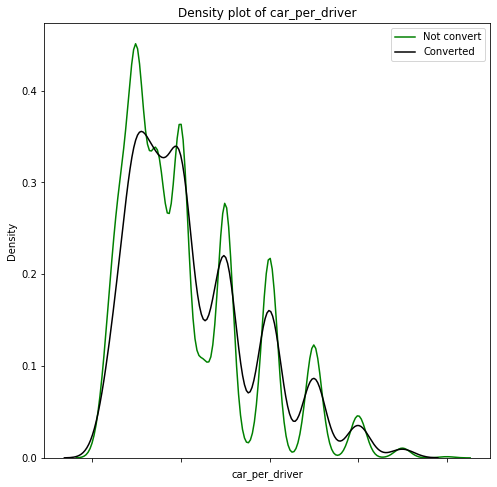

In [ ]:
car_per_driver_df = policy.assign(car_per_driver = lambda x: x.total_number_veh/x.number_drivers)[['policy_id', 'car_per_driver', 'convert_ind']]
fig, ax = plt.subplots(figsize = (8,8))
feature_0 = car_per_driver_df.loc[car_per_driver_df['convert_ind'] == 0]['car_per_driver']
feature_1 = car_per_driver_df.loc[car_per_driver_df['convert_ind'] == 1]['car_per_driver']
sns.distplot(
    feature_0,
    color = 'green', 
    ax = ax,
    hist=False,
    label='Not convert'  # show lable
    )
sns.distplot(
    feature_1,
    color = 'black', # change the color to black for some contrast
    ax = ax,
    hist=False,
    label='Converted'
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_title(f'Density plot of car_per_driver')
plt.legend()
plt.show()

In [ ]:
car_per_driver_df[(car_per_driver_df.car_per_driver==0.5)&(car_per_driver_df.convert_ind==1)]

policy_id  car_per_driver  convert_ind
136    policy_10305             0.5            1
960     policy_1226             0.5            1
1263   policy_12999             0.5            1
1924   policy_14494             0.5            1
2045   policy_14783             0.5            1
...             ...             ...          ...
33726  policy_93420             0.5            1
33920  policy_93891             0.5            1
35479  policy_97301             0.5            1
35496  policy_97339             0.5            1
36059  policy_98448             0.5            1

[103 rows x 3 columns]

In [ ]:
def policy_check(policy_id):
    display(train.query(f'policy_id=="{policy_id}"')[['policy_id', 'convert_ind', 'number_drivers', 'total_number_veh', 'num_loaned_veh', 'num_owned_veh', 'num_owned_veh', 'primary_parking', 'gender', 'living_status', 'age', 'safty_rating', 'high_education_ind']])
    display(vehicles.query(f'policy_id=="{policy_id}"'))

In [ ]:
# Example 1
policy_check("policy_10127")

policy_id  convert_ind  number_drivers  total_number_veh  \
23439  policy_10127            0               3                 4   
23440  policy_10127            0               3                 4   
23441  policy_10127            0               3                 4   

       num_loaned_veh  num_owned_veh  num_owned_veh primary_parking gender  \
23439               1              3              3         unknown      F   
23440               1              3              3         unknown      M   
23441               1              3              3         unknown      F   

      living_status  age  safty_rating  high_education_ind  
23439          rent   50          73.0                   0  
23440     dependent   18          49.0                   0  
23441     dependent   17          33.0                   0

policy_id  car_no ownership_type   color  age  \
106194  policy_10127       1         loaned  silver  6.0   
106195  policy_10127       2          owned     red  4.0   

                        make_model  
106194  CHEVROLET : SILVERADO 1500  
106195     FORD : F-250 SUPER DUTY

In [ ]:
# Example 2
policy_check("policy_96616")

policy_id  convert_ind  number_drivers  total_number_veh  \
47  policy_96616            0               4                 2   
48  policy_96616            0               4                 2   
49  policy_96616            0               4                 2   
50  policy_96616            0               4                 2   

    num_loaned_veh  num_owned_veh  num_owned_veh primary_parking gender  \
47               0              2              2   home/driveway      M   
48               0              2              2   home/driveway      F   
49               0              2              2   home/driveway      M   
50               0              2              2   home/driveway      F   

   living_status  age  safty_rating  high_education_ind  
47           own   35          60.0                   0  
48           own   53          82.0                   1  
49     dependent   17          61.0                   0  
50     dependent   17          77.0                   0

policy_id  car_no ownership_type   color  age  \
110809  policy_96616       1          owned  silver  6.0   
110810  policy_96616       2          owned   black  1.0   
110811  policy_96616       3          owned   black  5.0   

                     make_model  
110809   FORD : TRANSIT CONNECT  
110810  DODGE : RAM 2500 PICKUP  
110811            FORD : FIESTA

In [ ]:
# Example 3
policy_check("policy_14783")

policy_id  convert_ind  number_drivers  total_number_veh  \
72548  policy_14783            1               4                 2   
72549  policy_14783            1               4                 2   
72550  policy_14783            1               4                 2   
72551  policy_14783            1               4                 2   

       num_loaned_veh  num_owned_veh  num_owned_veh primary_parking gender  \
72548               0              2              2         unknown      M   
72549               0              2              2         unknown      F   
72550               0              2              2         unknown      F   
72551               0              2              2         unknown      F   

      living_status  age  safty_rating  high_education_ind  
72548           own   60          85.0                   1  
72549           own   31          92.0                   1  
72550     dependent   20          75.0                   0  
72551     dependent   19          49.0                   0

policy_id  car_no ownership_type   color  age             make_model
24082  policy_14783       1          owned     red  3.0               BMW : Z8
24083  policy_14783       2         leased  silver  3.0              AUDI : Q7
24084  policy_14783       3         loaned   white  6.0  MERCEDES-BENZ : SL600
24085  policy_14783       4          owned   black  6.0   MERCEDES-BENZ : C350

In [ ]:
drivers = pd.read_csv(os.path.join(data_dir, 'drivers.csv'), index_col=0).reset_index(drop=True)

def drivers_check(policy_id):
    display(train.query(f'policy_id=="{policy_id}"')[['policy_id', 'convert_ind', 'number_drivers', 'total_number_veh', 'num_loaned_veh', 'num_owned_veh', 'num_owned_veh', 'primary_parking', 'gender', 'living_status', 'age', 'safty_rating', 'high_education_ind']])
    display(drivers.query(f'policy_id=="{policy_id}"'))

In [ ]:
drivers_check("policy_14783")

### Quote changes around mid 2017

In [ ]:
data2017 = train_fill.assign(is_after_drop = lambda x: (x.Quote_dt>='2017-06-01').map({True: "After mid 2017", False: "Before mid 2017"}) )

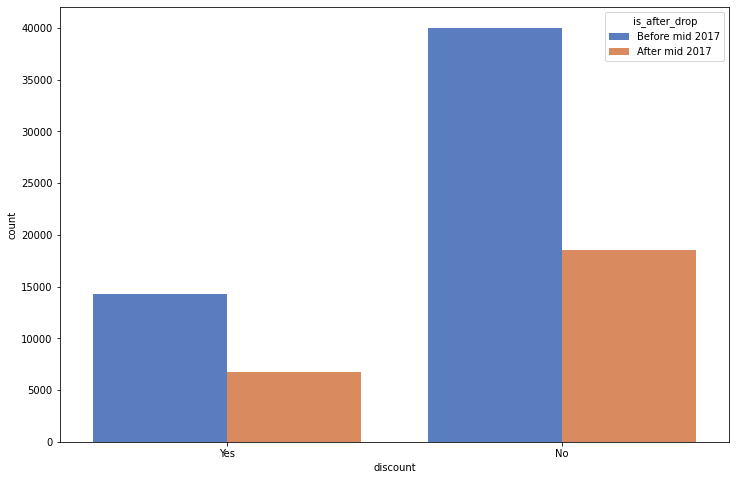

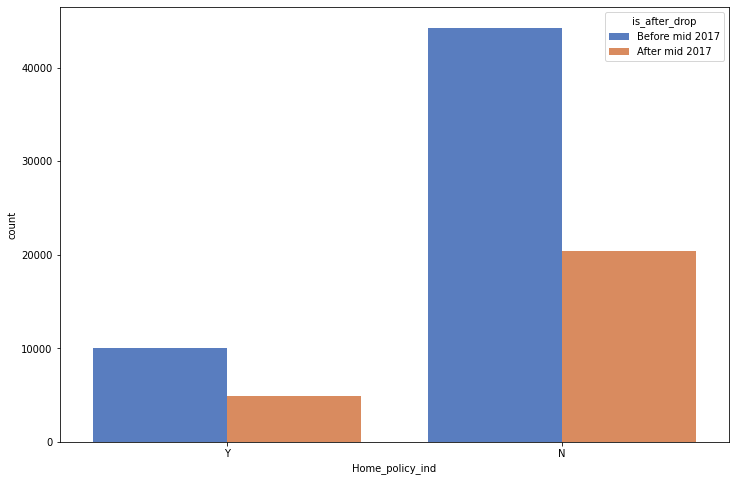

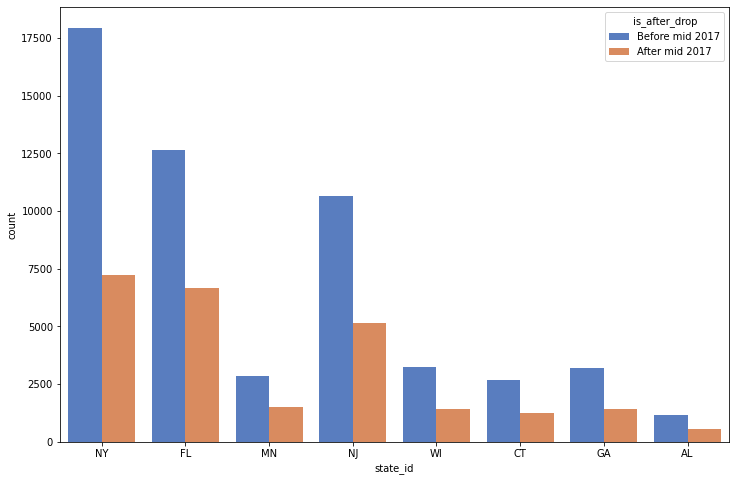

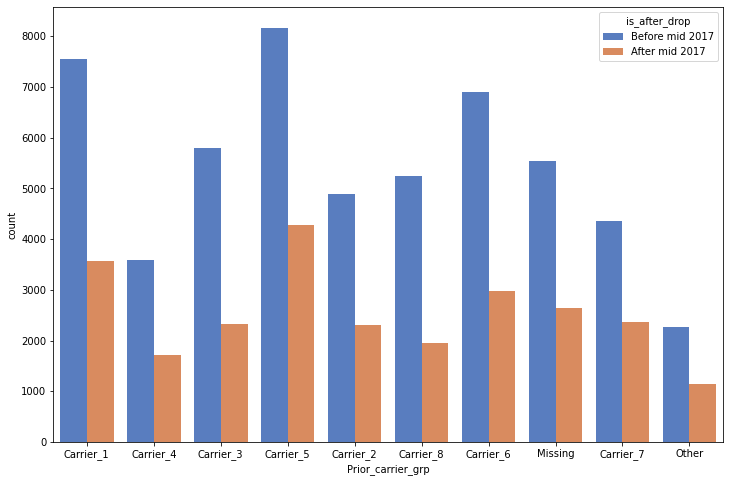

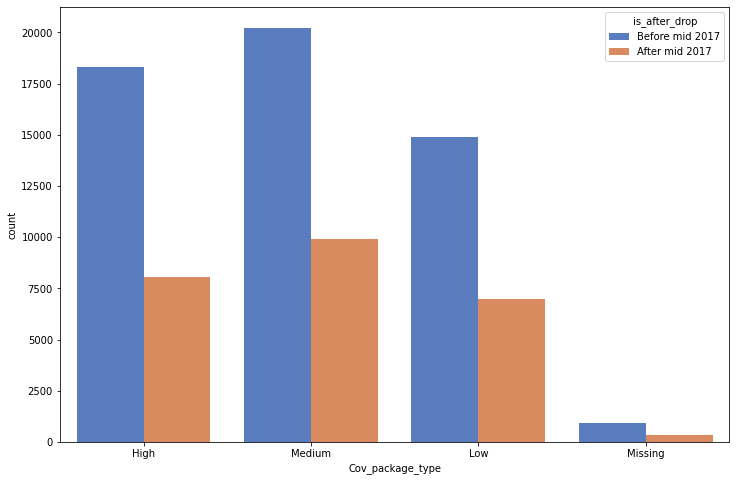

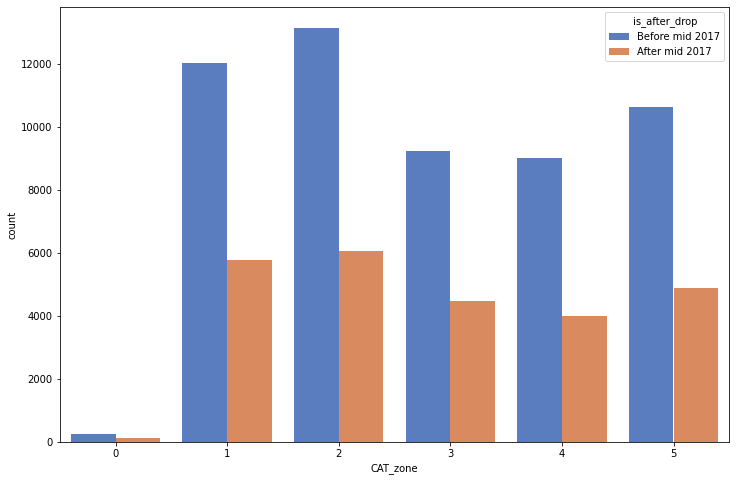

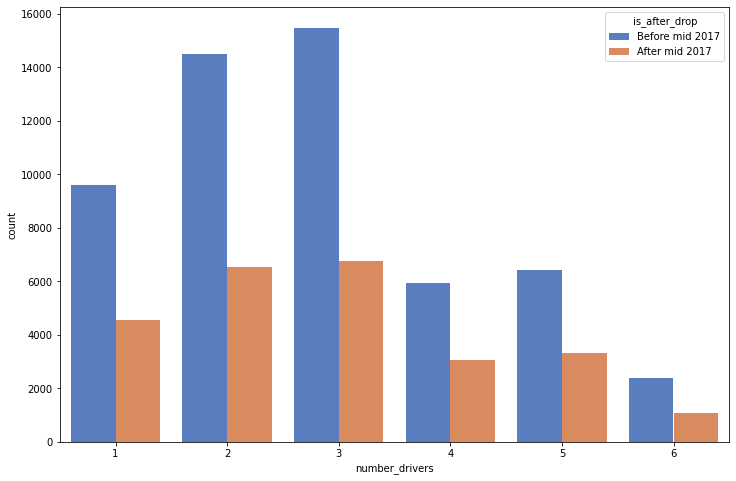

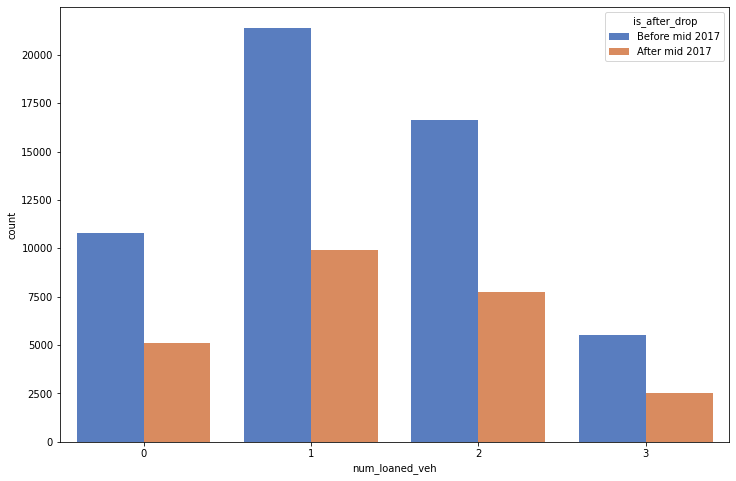

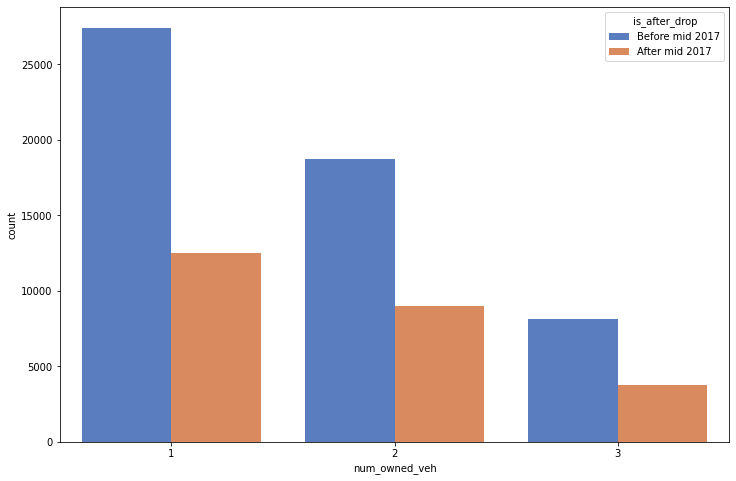

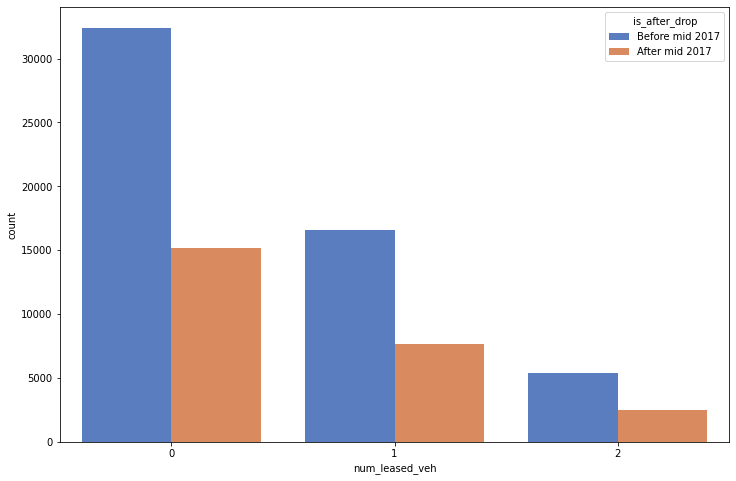

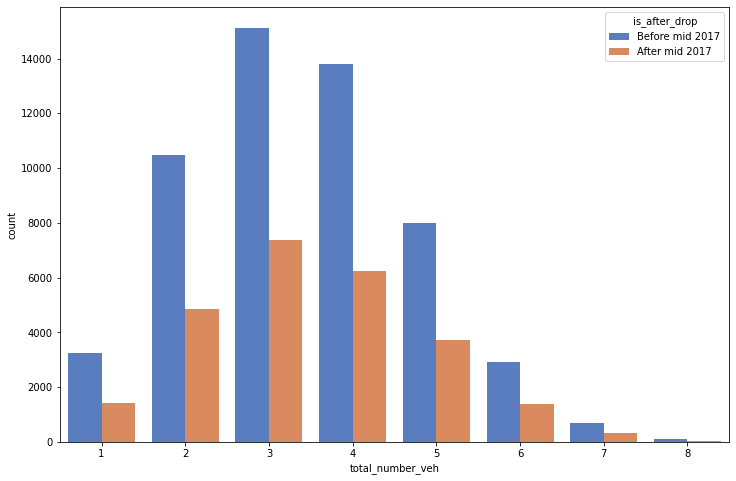

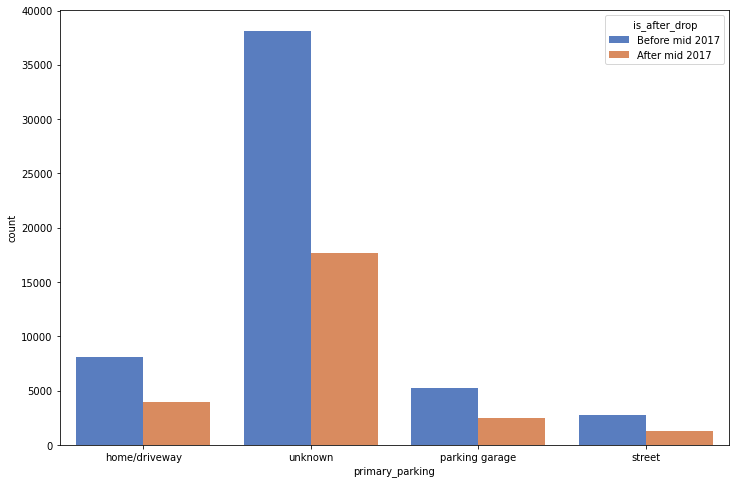

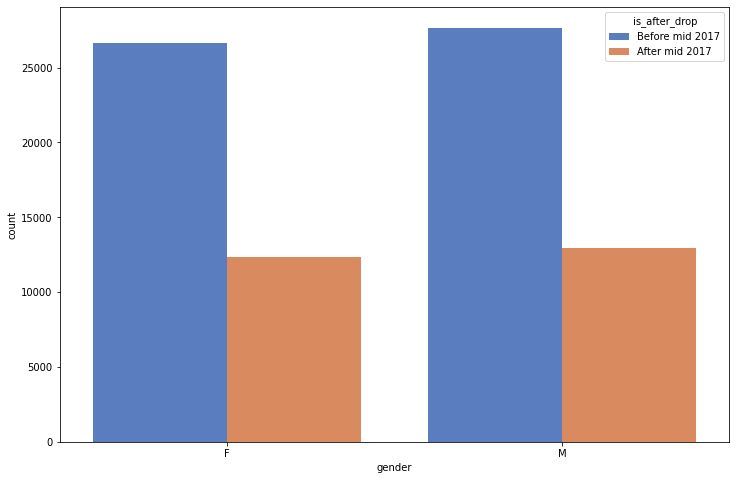

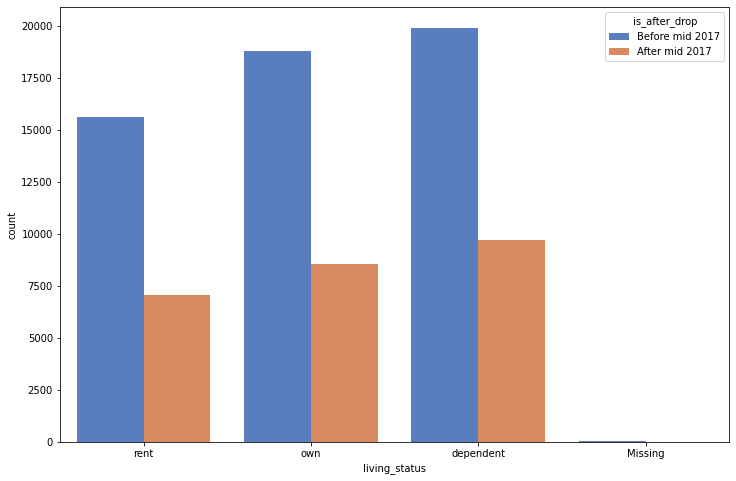

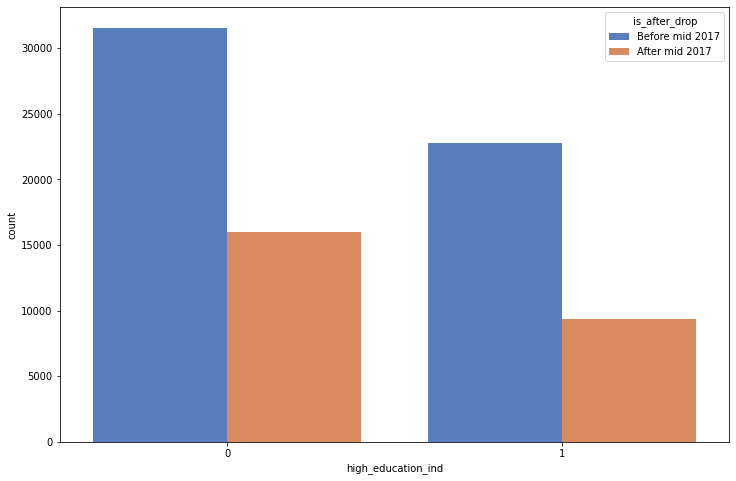

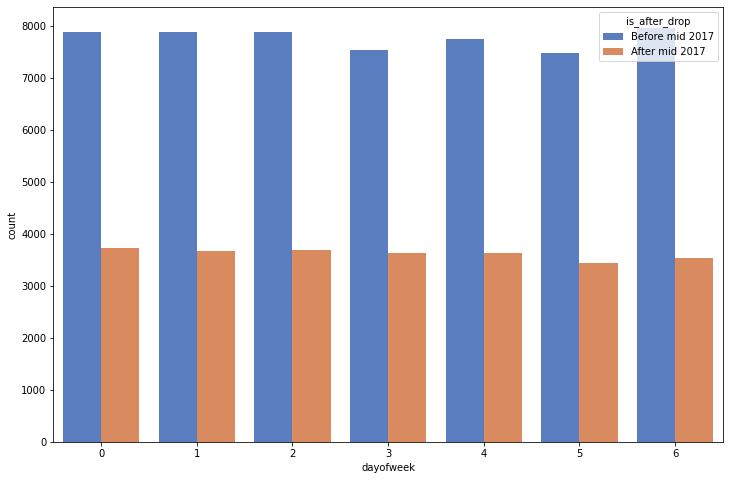

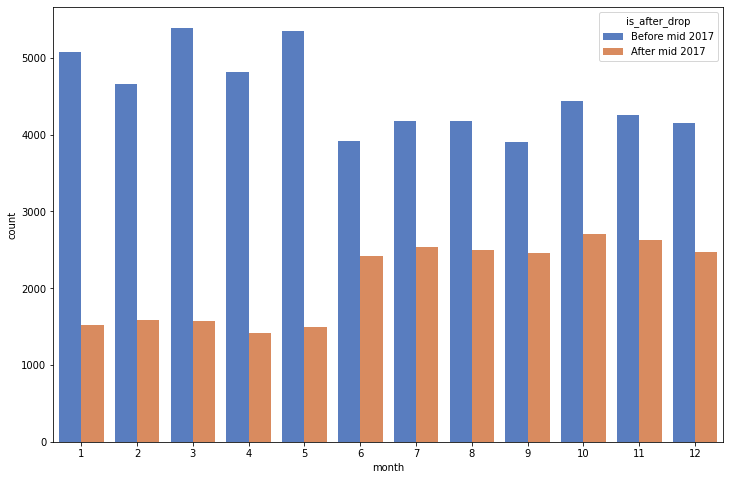

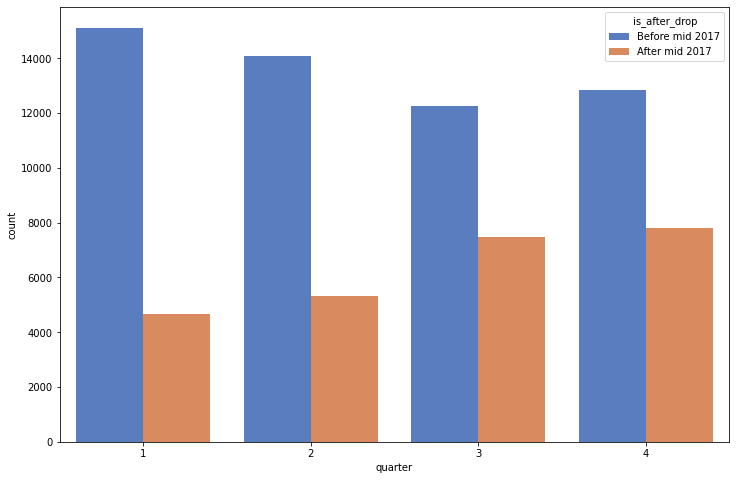

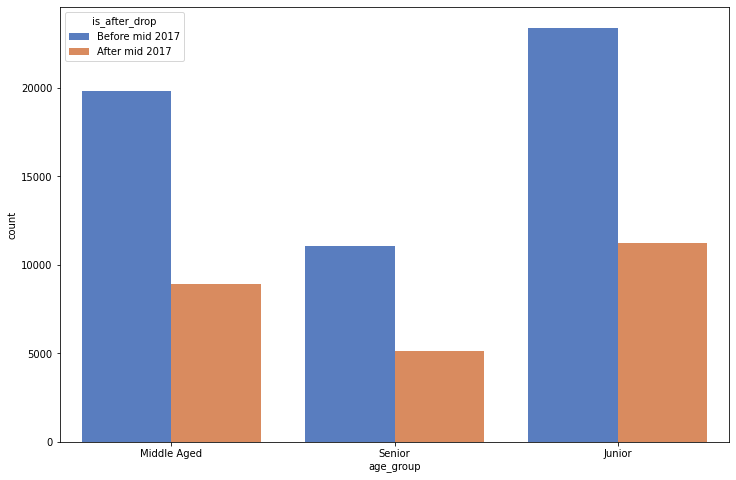

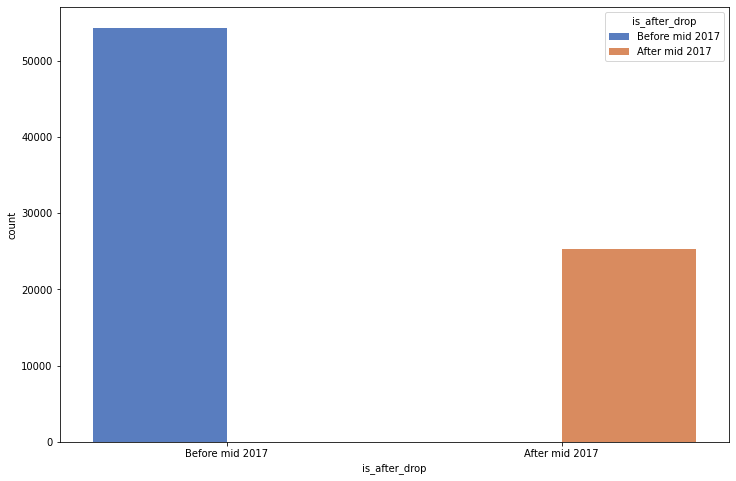

In [ ]:
int_cat_list = ['number_drivers', 'num_owned_veh', 'total_number_veh', 'month', 'quarter']  # these variables start with 1, will cause shift to right when plot
for i, predictor in enumerate(data2017.drop(['Quote_dt', 'zip', 'county_name', 'Agent_cd', 'policy_id', 'quoted_amt', 'credit_score', 'safty_rating', 'convert_ind'], axis=1)):
    plt.figure(i, figsize=(12,8))
    ax1 = sns.countplot(
        data=data2017, x=predictor, hue='is_after_drop',
        palette='muted')
plt.show()

Assumption: the number of group who were given discounts but still not convert increases after mid 2017

In [ ]:
data_before_mid2017 = train_fill.query('Quote_dt<"2017-06-01"')
data_before_mid2017.shape

(54323, 28)

In [ ]:
data_before_mid2017 = data_before_mid2017.assign(is_discount_not_convert = lambda x: ((x.discount=="Yes")&(x.convert_ind==0)).map({True: 1, False: 0}) )

In [ ]:
data_before_mid2017.is_discount_not_convert.value_counts()

0    41907
1    12416
Name: is_discount_not_convert, dtype: int64

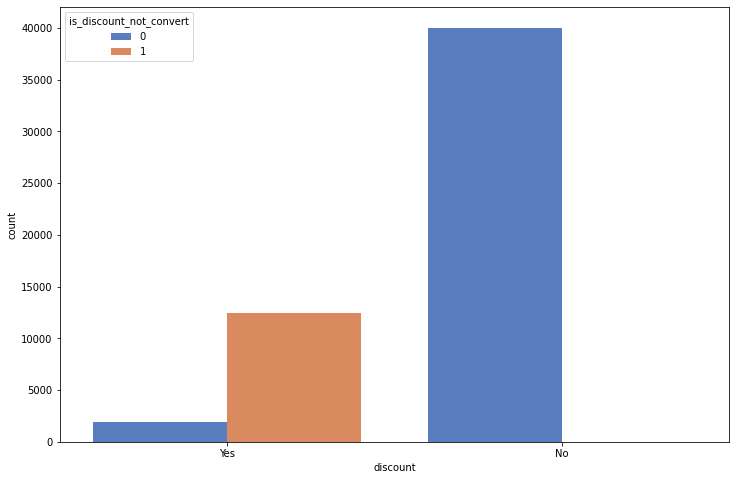

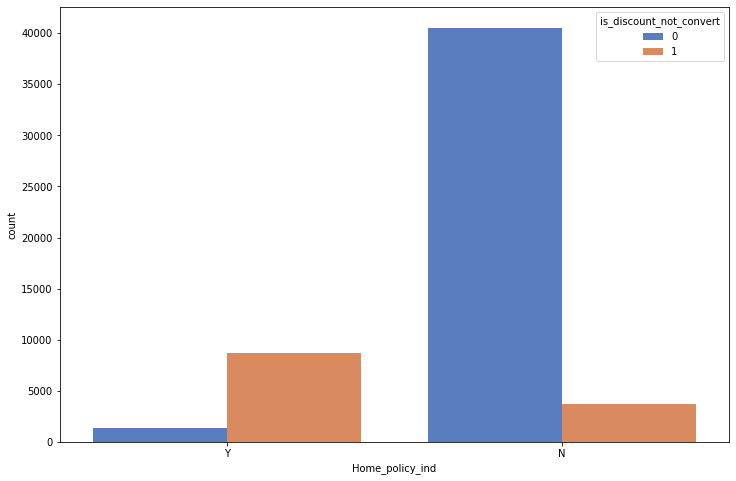

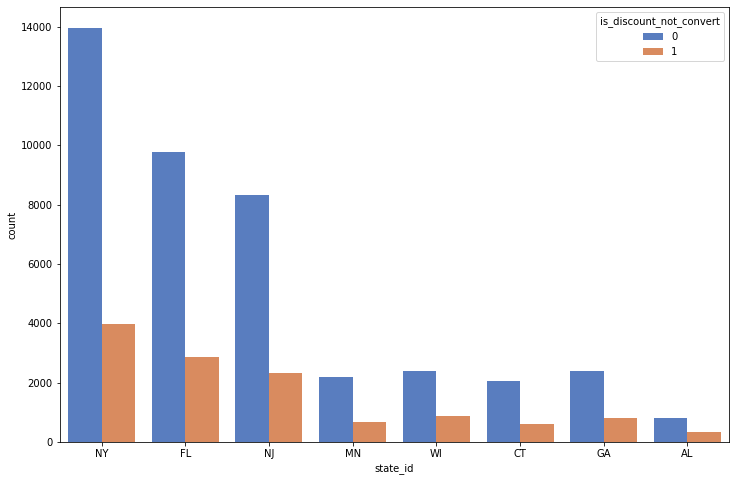

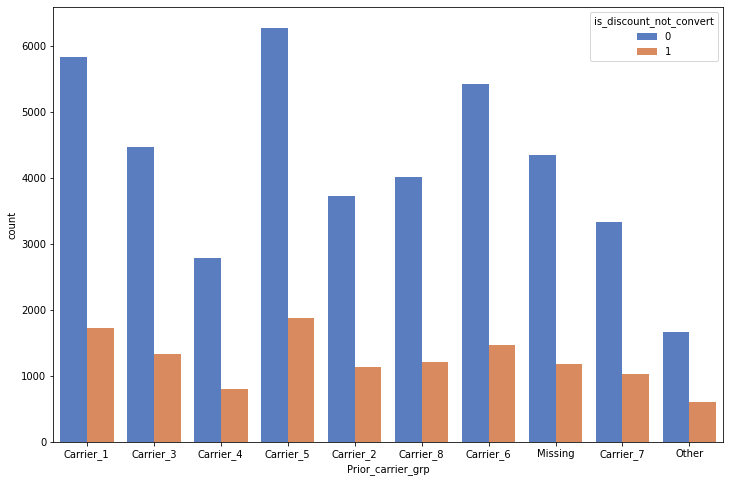

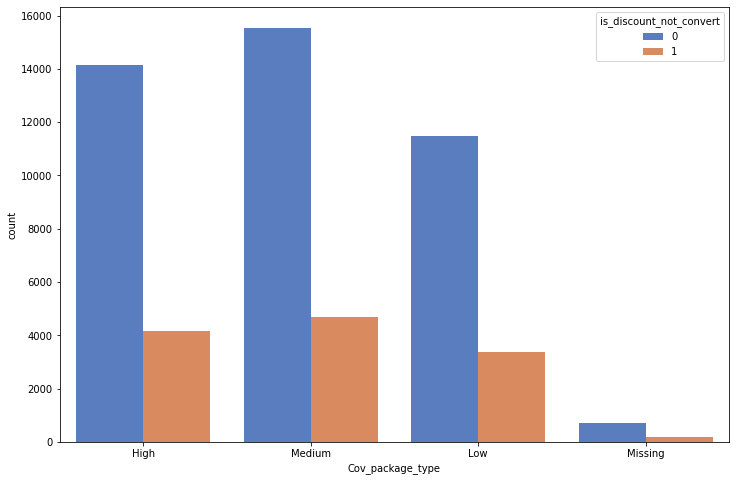

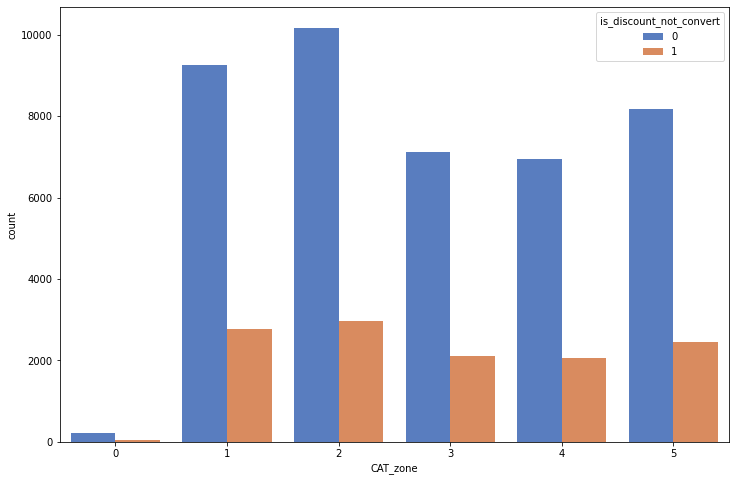

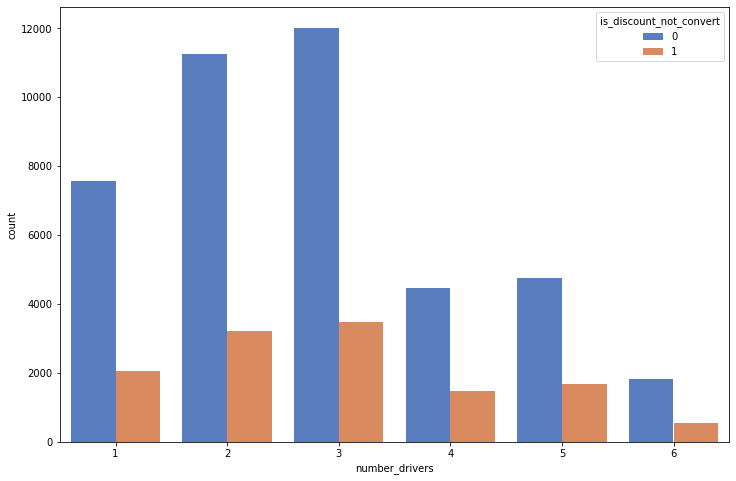

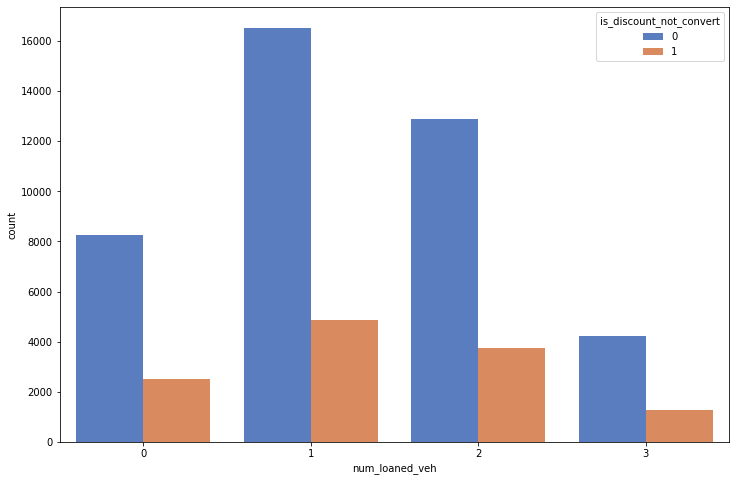

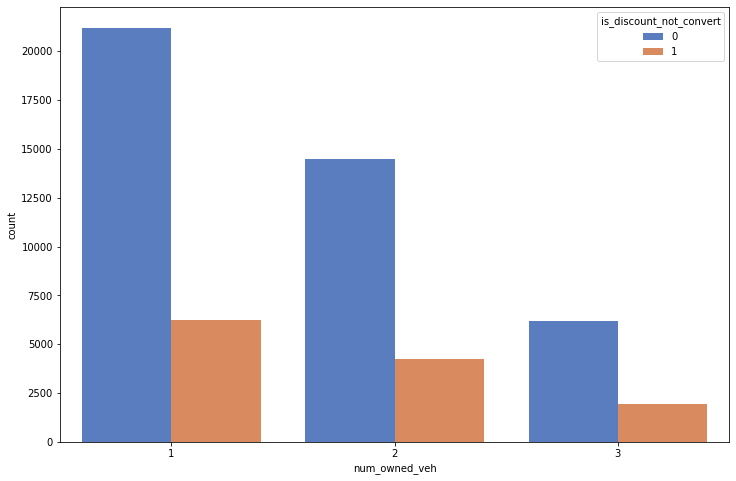

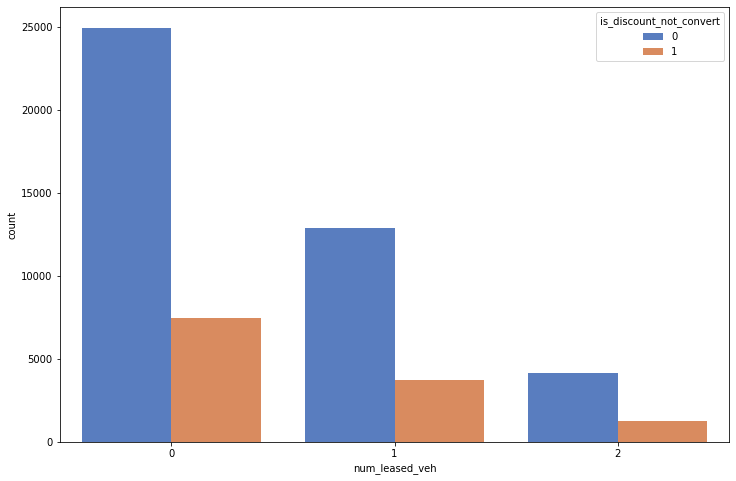

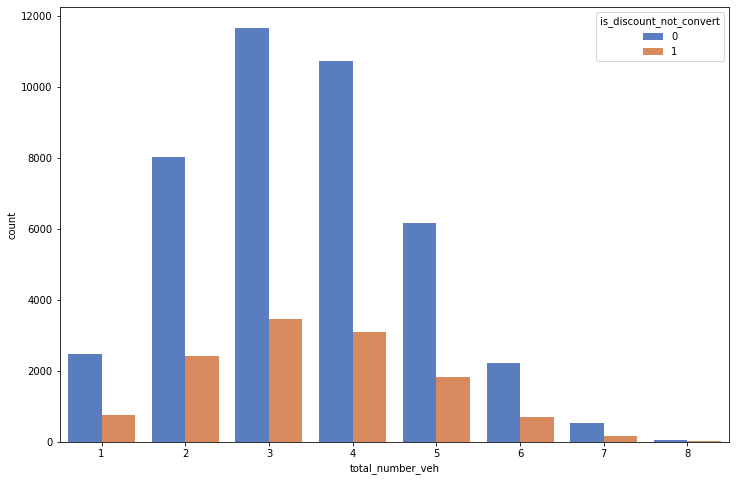

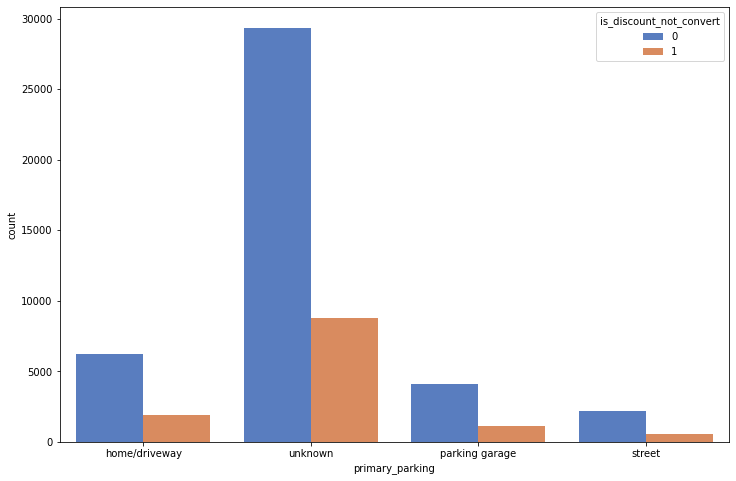

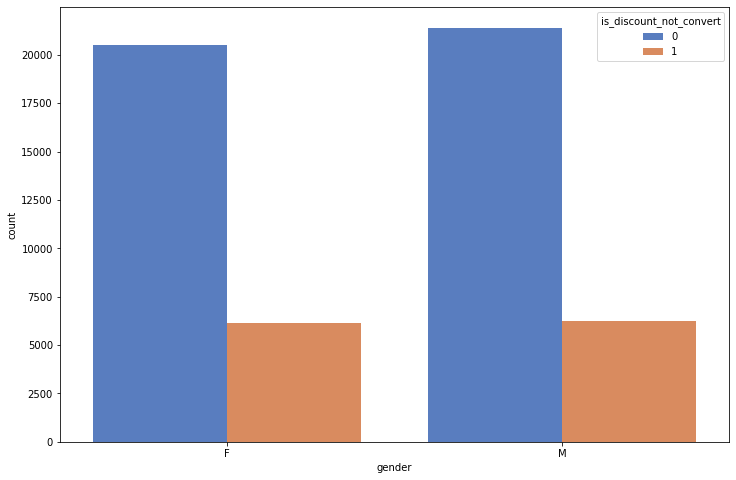

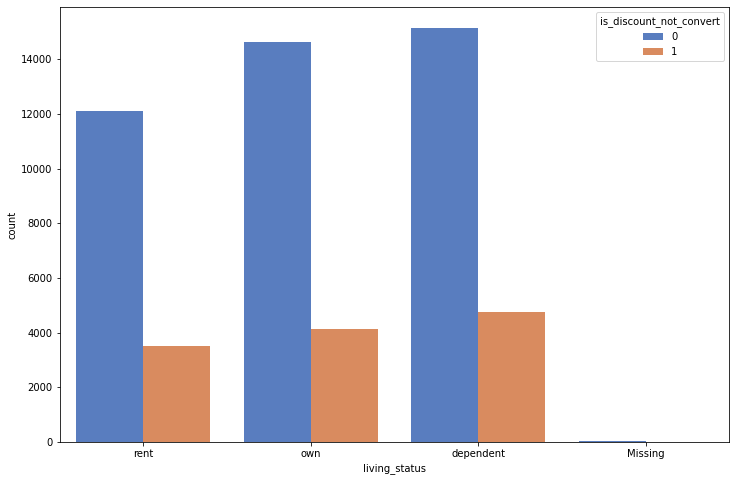

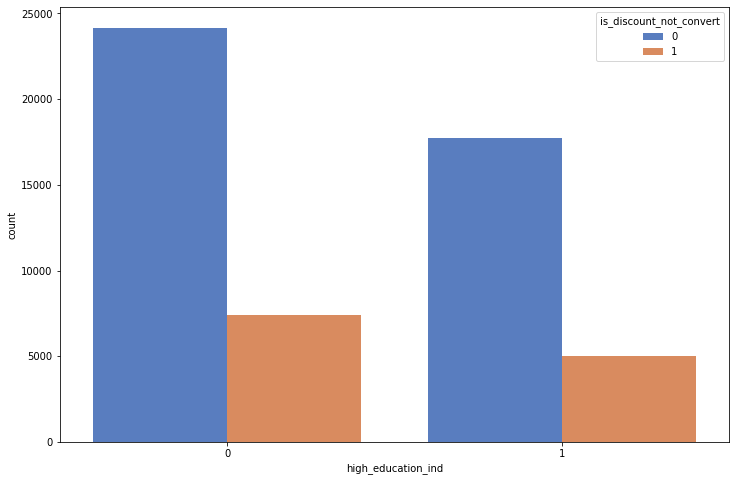

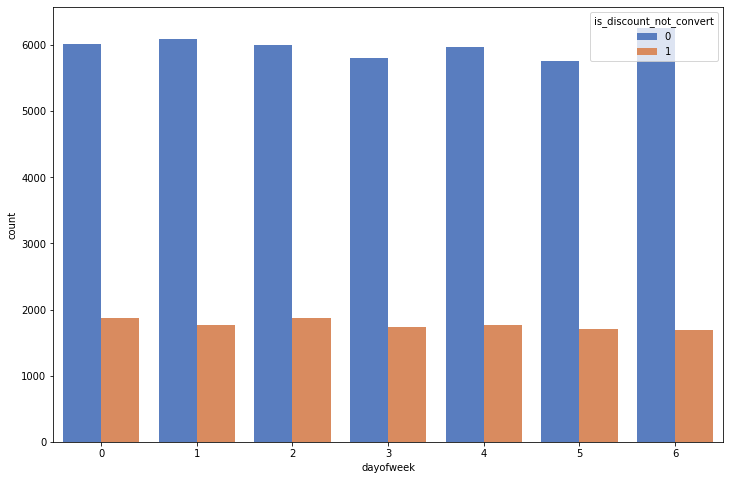

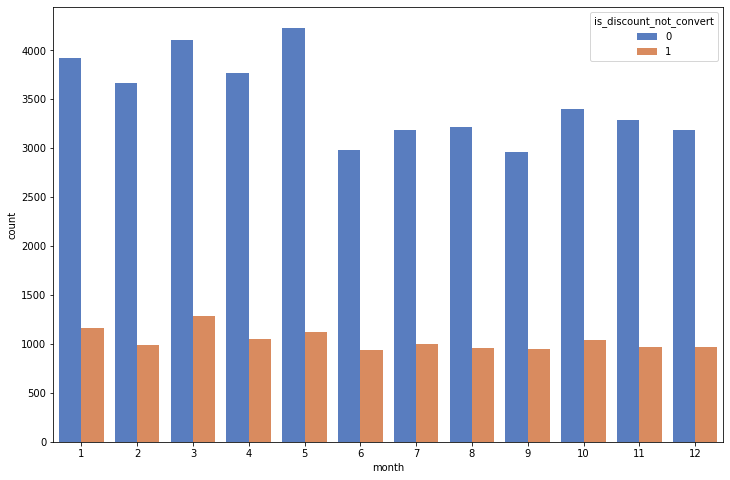

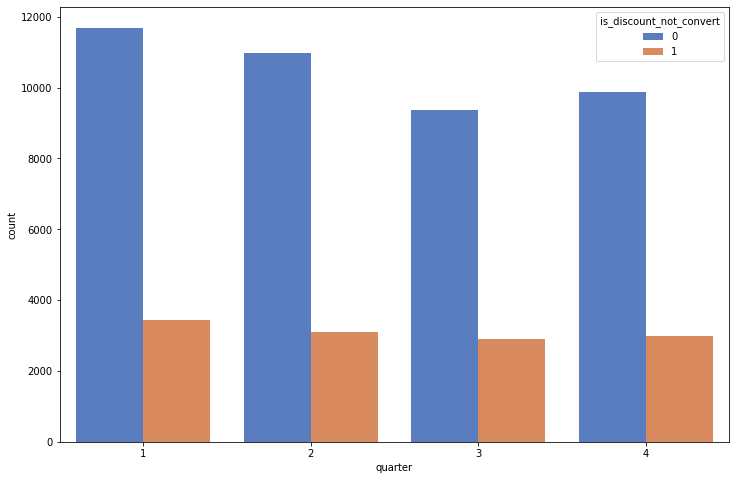

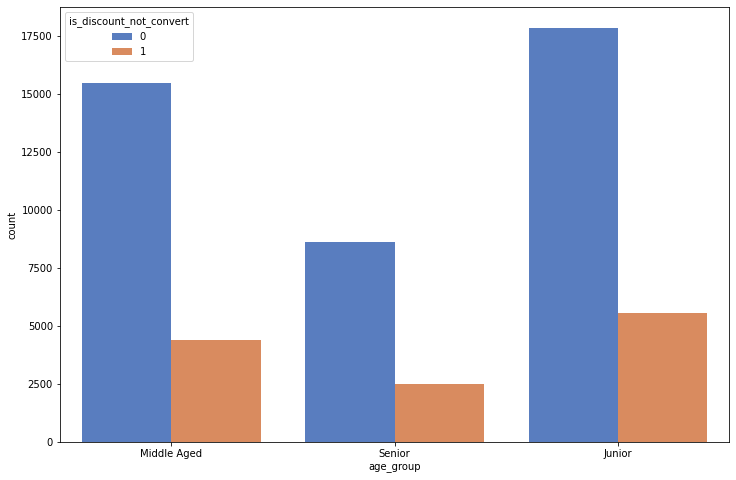

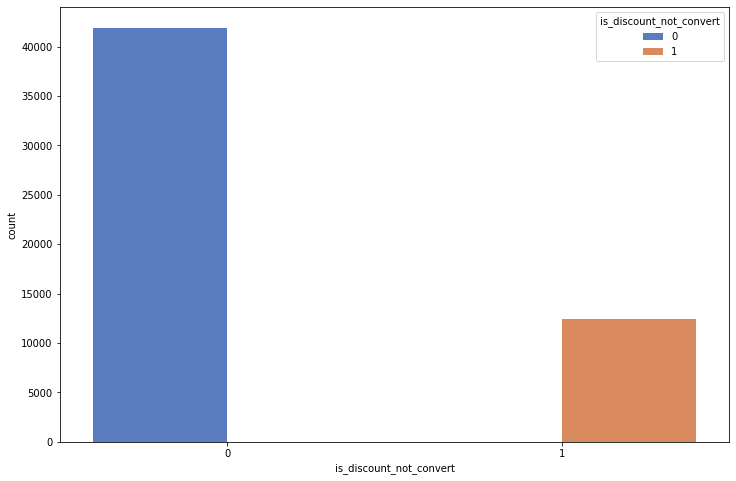

In [ ]:
for i, predictor in enumerate(data_before_mid2017.drop(['Quote_dt', 'zip', 'county_name', 'Agent_cd', 'policy_id', 'quoted_amt', 'credit_score', 'safty_rating', 'convert_ind'], axis=1)):
    plt.figure(i, figsize=(12,8))
    ax1 = sns.countplot(
        data=data_before_mid2017, x=predictor, hue='is_discount_not_convert',
        palette='muted')
plt.show()

How does quoted amount change over time?

In [ ]:
train_fill.head()

Quote_dt discount Home_policy_ind    zip state_id county_name  Agent_cd  \
0 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
1 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
3 2018-09-03       No               N  11548       NY      Nassau  32759856   
4 2018-09-03       No               N  11548       NY      Nassau  32759856   
6 2016-05-18       No               N  14622       NY      Monroe  15675431   

  Prior_carrier_grp Cov_package_type  CAT_zone     policy_id  number_drivers  \
0         Carrier_1             High         2  policy_87209               2   
1         Carrier_1             High         2  policy_87209               2   
3         Carrier_4           Medium         2  policy_91413               2   
4         Carrier_4           Medium         2  policy_91413               2   
6         Carrier_3           Medium         4  policy_71845               2   

   num_loaned_veh  num_owned_veh  num_leased_veh  total_number_veh  \
0               1              2               0                 3   
1               1              2               0                 3   
3               1              2               1                 4   
4               1              2               1                 4   
6               0              1               2                 3   

   convert_ind primary_parking gender living_status  high_education_ind  \
0            0   home/driveway      F          rent                   1   
1            0   home/driveway      M          rent                   0   
3            0         unknown      F          rent                   1   
4            0         unknown      M          rent                   0   
6            0         unknown      M           own                   1   

   dayofweek  month  quarter    age_group  quoted_amt  credit_score  \
0          2      1        1  Middle Aged      5153.0         613.0   
1          2      1        1       Senior      5153.0         613.0   
3          0      9        3  Middle Aged      3090.0         631.0   
4          0      9        3  Middle Aged      3090.0         631.0   
6          2      5        2       Senior     14917.0         602.0   

   safty_rating  
0          78.0  
1          70.0  
3          79.0  
4          61.0  
6          94.0

In [ ]:
qm_trend = train_fill.set_index('Quote_dt')['quoted_amt'].resample('M').apply(['mean', "median"]).rename(columns={'mean':"avg_quoted_amt", 'median':"median_quoted_amt"})
qm_trend.head()

avg_quoted_amt  median_quoted_amt
Quote_dt                                     
2015-01-31     5697.442298             3742.0
2015-02-28     5766.863889             3876.5
2015-03-31     6022.605026             3881.0
2015-04-30     5715.209171             3717.0
2015-05-31     5846.317374             3730.0

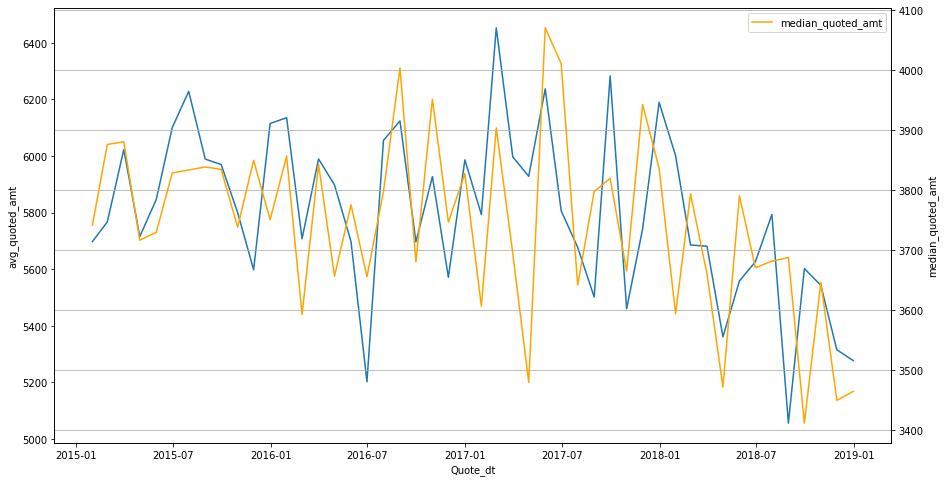

In [ ]:
plt.figure(figsize=(15,8))
ax1 = sns.lineplot(
    data=qm_trend, x='Quote_dt', y='avg_quoted_amt',
    label="avg_quoted_amt")
ax2 = ax1.twinx()
sns.lineplot(
    data=qm_trend, x='Quote_dt', y='median_quoted_amt',
    ax=ax2, color='orange', label='median_quoted_amt')
ax1.legend([ax1,ax2], ['avg_quoted_amt', 'median_quoted_amt'], loc=0)
plt.grid()
plt.show()

### New York state and others

Starting from the beginning of 2017, the quotes from NY, FL, NJ started to **drop seriously**.

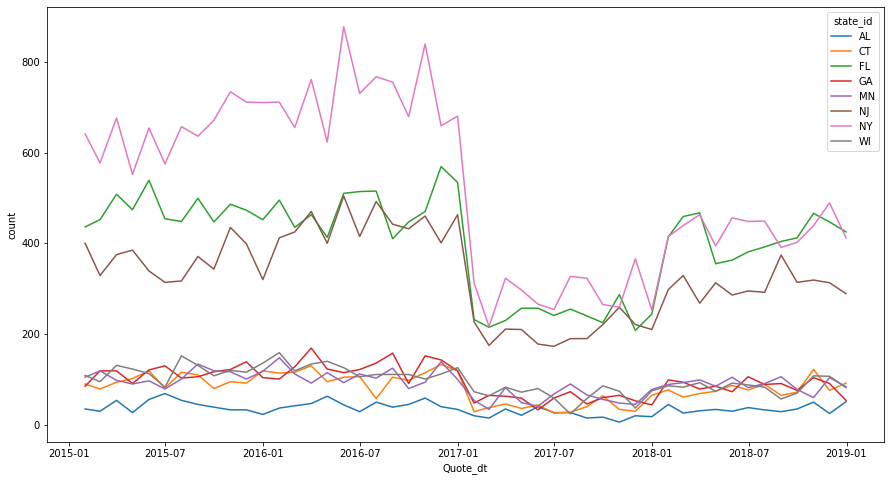

In [ ]:
States_customer = train_fill.set_index('Quote_dt').groupby([pd.Grouper(freq='M'), 'state_id'])['convert_ind'].agg(['sum', 'count']).reset_index(drop=False)
plt.figure(figsize=(15,8))
sns.lineplot(
    data=States_customer, x='Quote_dt', y='count', hue='state_id')
plt.show()

**Conduct hypothesis test on NY, NJ, FL**

In [ ]:
discount_df_NY = pd.merge(
    policy.query('(state_id in ["NY", "NJ", "FL"]) & (convert_ind==0)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Not converted"}),
    policy.query('(state_id in ["NY", "NJ", "FL"]) & (convert_ind==1)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Converted"}),
    on='discount'
)
discount_df_NY

discount  Not converted  Converted
0       No          18265       2350
1      Yes           6191       1057

In [ ]:
n_control = discount_df_NY.sum(1)[0]
n_test = discount_df_NY.sum(1)[1]
convert_control = discount_df_NY.query('discount=="No"')['Converted'].values[0]
convert_test = discount_df_NY.query('discount=="Yes"')['Converted'].values[0]

z_score, p_value = sp.proportions_ztest([convert_control, convert_test], [n_control, n_test], alternative='smaller')
print('z score:', z_score, '，p-value:', p_value)

z score: -7.116899403526127 ，p-value: 5.519099395300579e-13


In [ ]:
discount_df_NY_2017 = pd.merge(
    policy.query('(Quote_dt>="2017-07-01") & (state_id in ["NY", "NJ", "FL"]) & (convert_ind==0)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Not converted"}),
    policy.query('(Quote_dt>="2017-07-01") & (state_id in ["NY", "NJ", "FL"]) & (convert_ind==1)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Converted"}),
    on='discount'
)
discount_df_NY_2017

discount  Not converted  Converted
0       No           5515        708
1      Yes           2011        250

In [ ]:
n_control = discount_df_NY_2017.sum(1)[0]
n_test = discount_df_NY_2017.sum(1)[1]
convert_control = discount_df_NY_2017.query('discount=="No"')['Converted'].values[0]
convert_test = discount_df_NY_2017.query('discount=="Yes"')['Converted'].values[0]

z_score, p_value = sp.proportions_ztest([convert_control, convert_test], [n_control, n_test], alternative='smaller')
print('z score:', z_score, '，p-value:', p_value)

z score: 0.41187400550274456 ，p-value: 0.6597841126865689


In [ ]:
discount_df_other = pd.merge(
    policy.query('(state_id not in ["NY", "NJ", "FL"]) & (convert_ind==0)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Not converted"}),
    policy.query('(state_id not in ["NY", "NJ", "FL"]) & (convert_ind==1)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Converted"}),
    on='discount'
)
discount_df_other

discount  Not converted  Converted
0       No           6097        468
1      Yes           2198        245

In [ ]:
n_control = discount_df_other.sum(1)[0]
n_test = discount_df_other.sum(1)[1]
convert_control = discount_df_other.query('discount=="No"')['Converted'].values[0]
convert_test = discount_df_other.query('discount=="Yes"')['Converted'].values[0]

z_score, p_value = sp.proportions_ztest([convert_control, convert_test], [n_control, n_test], alternative='smaller')
print('z score:', z_score, '，p-value:', p_value)

z score: -4.532412234930505 ，p-value: 2.915695357420011e-06


In [ ]:
discount_df_other_2017 = pd.merge(
    policy.query('(Quote_dt>="2017-07-01") & (state_id not in ["NY", "NJ", "FL"]) & (convert_ind==0)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Not converted"}),
    policy.query('(Quote_dt>="2017-07-01") & (state_id not in ["NY", "NJ", "FL"]) & (convert_ind==1)').groupby(['discount'], as_index=False)['policy_id'].count().rename(columns={'policy_id': "Converted"}),
    on='discount'
)
discount_df_other_2017

discount  Not converted  Converted
0       No           1911        143
1      Yes            677         57

In [ ]:
n_control = discount_df_other_2017.sum(1)[0]
n_test = discount_df_other_2017.sum(1)[1]
convert_control = discount_df_other_2017.query('discount=="No"')['Converted'].values[0]
convert_test = discount_df_other_2017.query('discount=="Yes"')['Converted'].values[0]

z_score, p_value = sp.proportions_ztest([convert_control, convert_test], [n_control, n_test], alternative='smaller')
print('z score:', z_score, '，p-value:', p_value)

z score: -0.7242029106395231 ，p-value: 0.2344705859578381


### Family size

In [ ]:
family_df = train_fill[['policy_id', 'number_drivers', 'gender', 'living_status', 'high_education_ind', 'age', 'convert_ind']].copy()
family_df.head()

policy_id  number_drivers gender living_status  high_education_ind  age  \
0  policy_87209               2      F          rent                   1   41   
1  policy_87209               2      M          rent                   0   58   
3  policy_91413               2      F          rent                   1   43   
4  policy_91413               2      M          rent                   0   55   
6  policy_71845               2      M           own                   1   74   

   convert_ind  
0            0  
1            0  
3            0  
4            0  
6            0

In [ ]:
adults = family_df.iloc[np.where(family_df.living_status != 'dependent')].groupby('policy_id', as_index=False)['convert_ind'].count().rename(columns={'convert_ind': 'adult_count'})
children = family_df.iloc[np.where(family_df.living_status == 'dependent')].groupby('policy_id', as_index=False)['convert_ind'].count().rename(columns={'convert_ind': 'children_count'})
family_df = pd.merge(family_df, adults, on='policy_id', how='left')
family_df['adult_count'] = family_df['adult_count'].fillna(0.0)  # there are certain families have no adult
family_df = pd.merge(family_df, children, on='policy_id', how='left')
family_df['children_count'] = family_df['children_count'].fillna(0.0)  # there are certain families have no children
family_df.head()

policy_id  number_drivers gender living_status  high_education_ind  age  \
0  policy_87209               2      F          rent                   1   41   
1  policy_87209               2      M          rent                   0   58   
2  policy_91413               2      F          rent                   1   43   
3  policy_91413               2      M          rent                   0   55   
4  policy_71845               2      M           own                   1   74   

   convert_ind  adult_count  children_count  
0            0          2.0             0.0  
1            0          2.0             0.0  
2            0          2.0             0.0  
3            0          2.0             0.0  
4            0          2.0             0.0

In [ ]:
family_df.shape

(79615, 10)

In [ ]:
family_df = family_df.assign(
    family_status=lambda x: np.where(
        (x.adult_count == 2) & (x.children_count == 0), "Couple", np.where(
            (x.adult_count == 1) & (x.children_count > 0), "Single Parent", np.where(
                (x.adult_count == 1) & (x.children_count == 0), "Single Adult", np.where(
                    x.adult_count == 0, "Dependent Child", "Family"
                )
            )
        )
    )
)
family_df.head()

policy_id  number_drivers gender living_status  high_education_ind  age  \
0  policy_87209               2      F          rent                   1   41   
1  policy_87209               2      M          rent                   0   58   
2  policy_91413               2      F          rent                   1   43   
3  policy_91413               2      M          rent                   0   55   
4  policy_71845               2      M           own                   1   74   

   convert_ind  adult_count  children_count family_status  
0            0          2.0             0.0        Couple  
1            0          2.0             0.0        Couple  
2            0          2.0             0.0        Couple  
3            0          2.0             0.0        Couple  
4            0          2.0             0.0        Couple

In [ ]:
# children living status is missing, however still a couple
policy_26680_family = family_df.iloc[np.where(family_df.policy_id=="policy_26680")].replace("Family", "Couple")
family_df[lambda x: x.policy_id=="policy_26680"] = policy_26680_family

In [ ]:
family_df[lambda x: x.policy_id=="policy_26680"]

policy_id  number_drivers gender living_status  high_education_ind  \
35983  policy_26680               3      M          rent                   0   
35984  policy_26680               3      F          rent                   1   
35985  policy_26680               3      F       Missing                   0   

       age  convert_ind  adult_count  children_count family_status  
35983   57            1          3.0             0.0        Couple  
35984   46            1          3.0             0.0        Couple  
35985   16            1          3.0             0.0        Couple

In [ ]:
family_df.family_status.value_counts()

Family             26905
Single Parent      23160
Couple             15373
Single Adult       12458
Dependent Child     1719
Name: family_status, dtype: int64

In [ ]:
family_df.head()

policy_id  number_drivers gender living_status  high_education_ind  age  \
0  policy_87209               2      F          rent                   1   41   
1  policy_87209               2      M          rent                   0   58   
2  policy_91413               2      F          rent                   1   43   
3  policy_91413               2      M          rent                   0   55   
4  policy_71845               2      M           own                   1   74   

   convert_ind  adult_count  children_count family_status  
0            0          2.0             0.0        Couple  
1            0          2.0             0.0        Couple  
2            0          2.0             0.0        Couple  
3            0          2.0             0.0        Couple  
4            0          2.0             0.0        Couple

Discover different family traits

In [ ]:
policy_dt = train_fill.groupby('policy_id', as_index= False).first()[['Quote_dt', 'policy_id']]
policy_family = family_df.groupby('policy_id', as_index= False).first()[['policy_id', 'number_drivers', 'convert_ind', 'family_status']]
ts_family = pd.merge(policy_dt, policy_family, on='policy_id', how='left')
ts_family.head()

Quote_dt     policy_id  number_drivers  convert_ind  family_status
0 2017-06-11    policy_100               2            0  Single Parent
1 2018-03-24   policy_1000               1            0   Single Adult
2 2018-07-04  policy_10002               5            0  Single Parent
3 2015-10-21  policy_10004               5            0         Family
4 2016-10-05  policy_10005               3            0         Family

In [ ]:
cnt_family = ts_family.groupby('family_status', as_index=False).count()[['family_status','policy_id']].rename(columns={'policy_id': 'count'})
fig = px.pie(cnt_family,
             values='count', names='family_status')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    legend_title="Discount"
)
fig.show()

In [ ]:
fm = co = ts_family.query('family_status=="Family"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
co = ts_family.query('family_status=="Couple"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
sp = ts_family.query('family_status=="Single Parent"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
sa = ts_family.query('family_status=="Single Adult"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])
dc = ts_family.query('family_status=="Dependent Child"').resample("M",on='Quote_dt')['convert_ind'].agg(['sum','count']).reset_index(drop=False).assign(cov_rate = lambda x: x['sum']/x['count'])



In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=fm["Quote_dt"], y=fm["cov_rate"],
                    mode='lines', name='Family'))
fig.add_trace(go.Scatter(x=co["Quote_dt"], y=co["cov_rate"],
                    mode='lines', name='Couple'))
fig.add_trace(go.Scatter(x=sp["Quote_dt"], y=sp["cov_rate"],
                    mode='lines', name='Single Parent'))
fig.add_trace(go.Scatter(x=sa["Quote_dt"], y=sa["cov_rate"],
                    mode='lines', name='Single Adult'))
fig.add_trace(go.Scatter(x=dc["Quote_dt"], y=dc["cov_rate"],
                    mode='lines', name='Dependent Child'))
fig.update_layout(
    title='Discount & Conversion Rate',
    xaxis_title='Time',
    yaxis_title='Conversion Rate',
    legend_title="Family Status"
)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=fm["Quote_dt"], y=fm["count"],
                    mode='lines', name='Family'))
fig.add_trace(go.Scatter(x=co["Quote_dt"], y=co["count"],
                    mode='lines', name='Couple'))
fig.add_trace(go.Scatter(x=sp["Quote_dt"], y=sp["count"],
                    mode='lines', name='Single Parent'))
fig.add_trace(go.Scatter(x=sa["Quote_dt"], y=sa["count"],
                    mode='lines', name='Single Adult'))
fig.add_trace(go.Scatter(x=dc["Quote_dt"], y=dc["count"],
                    mode='lines', name='Dependent Child'))
fig.update_layout(
    title='Discount & Conversion Rate',
    xaxis_title='Time',
    yaxis_title='Num of quotes',
    legend_title="Family Status"
)
fig.show()

In [ ]:
# fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.08)

# fig.append_trace(go.Scatter(x=fm["Quote_dt"], y=fm["cov_rate"],
#                     mode='lines', name='Family'), row=1, col=1)
# fig.append_trace(go.Scatter(x=co["Quote_dt"], y=co["cov_rate"],
#                     mode='lines', name='Couple'), row=1, col=1)
# fig.append_trace(go.Scatter(x=sp["Quote_dt"], y=sp["cov_rate"],
#                     mode='lines', name='Single Parent'), row=1, col=1)
# fig.append_trace(go.Scatter(x=sa["Quote_dt"], y=sa["cov_rate"],
#                     mode='lines', name='Single Adult'), row=1, col=1)
# fig.append_trace(go.Scatter(x=dc["Quote_dt"], y=dc["cov_rate"],
#                     mode='lines', name='Dependent Child'), row=1, col=1)

# fig.append_trace(go.Scatter(x=co["Quote_dt"], y=co["count"],
#                     mode='lines', name='Couple', legendgroup='group1', showlegend=False), row=2, col=1)
# fig.append_trace(go.Scatter(x=sp["Quote_dt"], y=sp["count"],
#                     mode='lines', name='Single Parent', legendgroup='group2', showlegend=False), row=2, col=1)
# fig.append_trace(go.Scatter(x=sa["Quote_dt"], y=sa["count"],
#                     mode='lines', name='Single Adult', legendgroup='group3', showlegend=False), row=2, col=1)
# fig.append_trace(go.Scatter(x=dc["Quote_dt"], y=dc["count"],
#                     mode='lines', name='Dependent Child', legendgroup='group4', showlegend=False), row=2, col=1)

# fig.update_xaxes(title_text="Time", row=1, col=1)
# fig.update_xaxes(title_text="Time", row=2, col=1)
# fig.update_yaxes(title_text="Conversion Rate", row=1, col=1)
# fig.update_yaxes(title_text="Num of Quotes", row=2, col=1)
# fig.update_layout(
#     height=1000, width=1000,
#     margin=dict(r=5, l=5, t=5, b=5),
#     title='Family status conversion',
#     legend_title="Family Status"
# )
# fig.show()

In [ ]:
family_cov = get_conversion_rate(family_df, ['family_status']).sort_values('conversion_rate', ascending=False)
family_cov

family_status  num_converted  total  conversion_rate
0           Couple           2001  15373         0.130163
3     Single Adult           1586  12458         0.127308
2           Family           2485  26905         0.092362
1  Dependent Child            147   1719         0.085515
4    Single Parent           1764  23160         0.076166

In [ ]:
fig = px.bar(
    family_cov, x="family_status", y="conversion_rate"
)
fig.update_layout(
    width=600, height=600,
    yaxis_range=[0.05, 0.15],
    xaxis_title='')
fig.show()

## K-means clustering

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
def kmeans_prep(version=None, kmeans_feat=None):
    if version is None:
        df = load_df(train_test_split=False)
    elif version =='v1':
        df,_ = load_df(train_test_split=True)
        fill_na = True
    if kmeans_feat is None:
        kmeans_feat = ['age', 'credit_score', 'total_number_veh', 'quoted_amt',
                        'CAT_zone', 'state_id', 'discount','Prior_carrier_grp']
    df = df[kmeans_feat]
    print("------Processing Missing Values------")
    try:
        df['Prior_carrier_grp'] = df['Prior_carrier_grp'].fillna('Not Specified')
    except:
        print("Prior_carrier_grp is not in the feature list")
    print(f'Before removing NA: {df.shape[0]}', 
        f'After removing NA: {df.dropna().shape[0]}', 
        f'The difference is: {round(100*(df.dropna().shape[0]-df.shape[0])/df.shape[0])}%',
        sep='\n')
    if round(100*(df.dropna().shape[0]-df.shape[0])/df.shape[0]) > 10:
        print("WARNING: Too many rows dropped!")
        print(df.isna().sum()/df.shape[0])
        return None
    elif fill_na == True:
        num_var = df.select_dtypes(include=['float']).columns
        for i, predictor in enumerate(df.drop(columns=num_var)):
            try:
                df[predictor] = df[predictor].fillna('Missing')
            except:
                df[predictor] = df[predictor].fillna(0)
        for i, predictor in enumerate(df[num_var]):
            df[predictor] = df[predictor].fillna(df[predictor].mean())
    else:
        df = df.dropna()
    print("------Normalizing Variables------")
    for i, var in enumerate(df.select_dtypes(include=['float'])):
        mean = df[var].mean()
        std = df[var].std()
        df[var] = (df[var] - mean) / std
    print("------Getting Dummy Variables------")
    bins = [df['age'].min(), 35, 55, df['age'].max()]
    group_names = ['Junior', 'Middle Aged', 'Senior']
    df['age_group'] = pd.cut(df['age'], bins, labels=group_names, include_lowest=True).astype('object')
    df.drop('age', axis=1, inplace=True)
    df = pd.get_dummies(df)
    print("Success")
    return df



In [ ]:
kmeans_feat = ['age', 'credit_score', 'total_number_veh', 
                        'CAT_zone', 'state_id', 'discount','Prior_carrier_grp']
kmeans_df = kmeans_prep('v1', kmeans_feat)
kmeans_df.head()

------Processing Missing Values------
Before removing NA: 79615
After removing NA: 78711
The difference is: -1%
------Normalizing Variables------
------Getting Dummy Variables------
Success


credit_score  total_number_veh  CAT_zone  state_id_AL  state_id_CT  \
0     -0.369950                 3         2            0            0   
1     -0.369950                 3         2            0            0   
3     -0.140180                 4         2            0            0   
4     -0.140180                 4         2            0            0   
6     -0.510365                 3         4            0            0   

   state_id_FL  state_id_GA  state_id_MN  state_id_NJ  state_id_NY  \
0            0            0            0            0            1   
1            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   
6            0            0            0            0            1   

   state_id_WI  discount_No  discount_Yes  Prior_carrier_grp_Carrier_1  \
0            0            0             1                            1   
1            0            0             1                            1   
3            0            1             0                            0   
4            0            1             0                            0   
6            0            1             0                            0   

   Prior_carrier_grp_Carrier_2  Prior_carrier_grp_Carrier_3  \
0                            0                            0   
1                            0                            0   
3                            0                            0   
4                            0                            0   
6                            0                            1   

   Prior_carrier_grp_Carrier_4  Prior_carrier_grp_Carrier_5  \
0                            0                            0   
1                            0                            0   
3                            1                            0   
4                            1                            0   
6                            0                            0   

   Prior_carrier_grp_Carrier_6  Prior_carrier_grp_Carrier_7  \
0                            0                            0   
1                            0                            0   
3                            0                            0   
4                            0                            0   
6                            0                            0   

   Prior_carrier_grp_Carrier_8  Prior_carrier_grp_Not Specified  \
0                            0                                0   
1                            0                                0   
3                            0                                0   
4                            0                                0   
6                            0                                0   

   Prior_carrier_grp_Other  age_group_Junior  age_group_Middle Aged  \
0                        0                 0                      1   
1                        0                 0                      0   
3                        0                 0                      1   
4                        0                 0                      1   
6                        0                 0                      0   

   age_group_Senior  
0                 0  
1                 1  
3                 0  
4                 0  
6                 1

### K-means

In [ ]:
kmeans = KMeans(
			 init="random",
			 n_clusters=5,
			 n_init=10,
			 max_iter=300,
			 random_state=42
).fit(kmeans_df)

In [ ]:
print(kmeans.cluster_centers_)

[[ 2.91078912e+01 -3.16671228e-03  1.06314462e-05 -1.97824328e-02
   4.65249828e-04 -1.54874594e-02  9.24180206e-04]
 [-2.03697041e+01  4.37563139e-03 -4.44437262e-03 -9.69786667e-03
   4.51514802e-04 -3.62696866e-03 -2.70517185e-04]
 [ 1.69803823e-01 -8.94026175e-03  1.25672012e-02  2.27183756e-02
  -1.23722347e-03  1.59385351e-03  2.33950809e-03]
 [ 1.37538111e+01  2.52924751e-03 -3.73529086e-03  5.27395845e-03
   1.19398592e-04  1.13712500e-02 -1.91869123e-03]]


In [ ]:
Kmeans_centers = pd.DataFrame(kmeans.cluster_centers_, columns=kmeans_df.columns)
cat_cols = Kmeans_centers.drop(['credit_score'], axis=1).columns
Kmeans_centers[cat_cols] = Kmeans_centers[cat_cols].round(0).astype('int')
Kmeans_centers.head()

credit_score  total_number_veh  CAT_zone  state_id_AL  state_id_CT  \
0     -0.334081                 2         5            0            0   
1      0.706856                 2         2            0            0   
2     -0.349530                 5         4            0            0   
3     -0.849320                 3         2            0            0   
4      0.503879                 5         2            0            0   

   state_id_FL  state_id_GA  state_id_MN  state_id_NJ  state_id_NY  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   state_id_WI  discount_No  discount_Yes  Prior_carrier_grp_Carrier_1  \
0            0            1             0                            0   
1            0            1             0                            0   
2            0            1             0                            0   
3            0            1             0                            0   
4            0            1             0                            0   

   Prior_carrier_grp_Carrier_2  Prior_carrier_grp_Carrier_3  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   Prior_carrier_grp_Carrier_4  Prior_carrier_grp_Carrier_5  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   Prior_carrier_grp_Carrier_6  Prior_carrier_grp_Carrier_7  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   Prior_carrier_grp_Carrier_8  Prior_carrier_grp_Not Specified  \
0                            0                                0   
1                            0                                0   
2                            0                                0   
3                            0                                0   
4                            0                                0   

   Prior_carrier_grp_Other  age_group_Junior  age_group_Middle Aged  \
0                        0                 0                      0   
1                        0                 0                      0   
2                        0                 0                      0   
3                        0                 0                      0   
4                        0                 0                      0   

   age_group_Senior  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

## K-modes clustering

In [ ]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kmodes.kmodes import KModes

In [ ]:
train_df = train.copy()

In [ ]:
np.nanpercentile(train_df.quoted_amt, [30,60,80,100])

array([  2509.,   4554.,   7507., 108608.])

In [ ]:
bins = [train_df['age'].min(), 35, 55, train_df['age'].max()]
group_names = ['Junior', 'Middle Aged', 'Senior']
train_df['age_group'] = pd.cut(train_df['age'], bins, labels=group_names, include_lowest=True).astype('object')
train_df.drop('age', axis=1, inplace=True)
train_df['age_group'].value_counts()

Junior         34657
Middle Aged    28773
Senior         16185
Name: age_group, dtype: int64

In [ ]:
def kmodes_prep(version=None, kmodes_feat=None):
    if version is None:
        df = load_df(train_test_split=False)
    elif version =='v1':
        df,_ = load_df(train_test_split=True)
        fill_na = True
    if kmodes_feat is None:
        kmodes_feat = ['discount', 'Home_policy_ind', 'state_id', 'Prior_carrier_grp',
       'Cov_package_type', 'CAT_zone', 'number_drivers', 'total_number_veh',
       'primary_parking', 'gender', 'living_status', 'high_education_ind',
       'age', 'quoted_amt', 'credit_score', 'safty_rating']
    df = df[kmodes_feat]
    print("------Processing Numeric Values------")
    bins = [df['age'].min(), 35, 55, df['age'].max()]
    group_names = ['Junior', 'Middle Aged', 'Senior']
    df['age_group'] = pd.cut(df['age'], bins, labels=group_names, include_lowest=True).astype('object')
    df.drop('age', axis=1, inplace=True)
    df['quoted_amt'] = pd.cut(df['quoted_amt'], np.nanpercentile(train_df.quoted_amt, [0,30,60,80,100]), labels=["Low Quotes", "Average Quotes", "High Quotes", "Top Quotes"], include_lowest=True).astype('object')
    df['credit_score'] = pd.cut(df['credit_score'], np.nanpercentile(train_df.credit_score, [0,25,50,75,100]), labels=["Low Credit", "Average Credit", "High Credit", "Top Credit"], include_lowest=True).astype('object')
    df['safty_rating'] = pd.cut(df['safty_rating'], np.nanpercentile(train_df.safty_rating, [0,20,60,90,100]), labels=["Low safty_rating", "Average safty_rating", "High safty_rating", "Most safe"], include_lowest=True).astype('object')
    print("------Processing Missing Values------")
    try:
        df['Prior_carrier_grp'] = df['Prior_carrier_grp'].fillna('Not Specified')
    except:
        print("Fail to fill Prior_carrier_grp.")
    print(f'Before removing NA: {df.shape[0]}', 
        f'After removing NA: {df.dropna().shape[0]}', 
        f'The difference is: {round(100*(df.dropna().shape[0]-df.shape[0])/df.shape[0])}%',
        sep='\n')
    if round(100*(df.dropna().shape[0]-df.shape[0])/df.shape[0]) > 10:
        print("WARNING: Too many rows dropped!")
        print(df.isna().sum()/df.shape[0])
        return None
    elif fill_na == True:
        df = df.fillna(df.mode().iloc[0])
    else:
        df = df.dropna()
    print("Success")
    return df



In [ ]:
kmodes_df = kmodes_prep(version="v1")
kmodes_df.head()

------Processing Numeric Values------
------Processing Missing Values------
Before removing NA: 79615
After removing NA: 76783
The difference is: -4%
Success


discount Home_policy_ind state_id Prior_carrier_grp Cov_package_type  \
0      Yes               Y       NY         Carrier_1             High   
1      Yes               Y       NY         Carrier_1             High   
3       No               N       NY         Carrier_4           Medium   
4       No               N       NY         Carrier_4           Medium   
6       No               N       NY         Carrier_3           Medium   

   CAT_zone  number_drivers  total_number_veh primary_parking gender  \
0         2               2                 3   home/driveway      F   
1         2               2                 3   home/driveway      M   
3         2               2                 4         unknown      F   
4         2               2                 4         unknown      M   
6         4               2                 3         unknown      M   

  living_status  high_education_ind      quoted_amt    credit_score  \
0          rent                   1     High Quotes  Average Credit   
1          rent                   0     High Quotes  Average Credit   
3          rent                   1  Average Quotes  Average Credit   
4          rent                   0  Average Quotes  Average Credit   
6           own                   1      Top Quotes  Average Credit   

           safty_rating    age_group  
0     High safty_rating  Middle Aged  
1  Average safty_rating       Senior  
3     High safty_rating  Middle Aged  
4  Average safty_rating  Middle Aged  
6             Most safe       Senior

In [ ]:
kmodes_df.isna().sum()

discount              0
Home_policy_ind       0
state_id              0
Prior_carrier_grp     0
Cov_package_type      0
CAT_zone              0
number_drivers        0
total_number_veh      0
primary_parking       0
gender                0
living_status         0
high_education_ind    0
quoted_amt            0
credit_score          0
safty_rating          0
age_group             0
dtype: int64

In [ ]:
kmodes_matrix = kmodes_df.to_numpy()
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kmodes.fit_predict(kmodes_matrix)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})
df_cost

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


Cluster      Cost
0        1  732427.0
1        2  640668.0
2        3  599228.0
3        4  577789.0
4        5  567856.0
5        6  549893.0
6        7  544457.0
7        8  533671.0
8        9  534853.0

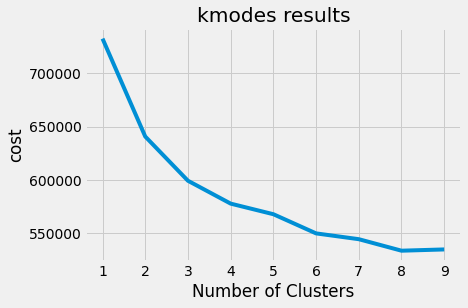

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 10), cost)
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("cost")
plt.title("kmodes results")
plt.show()

In [ ]:
kmodes = KModes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kmodes.fit(kmodes_matrix)

KModes(init='Huang', n_clusters=4, n_jobs=-1, random_state=0)

In [ ]:
Kmodes_centers = pd.DataFrame(kmodes.cluster_centroids_, columns=kmodes_df.columns)
Kmodes_centers.head()

discount Home_policy_ind state_id Prior_carrier_grp Cov_package_type  \
0       No               N       NY         Carrier_5             High   
1       No               N       NY         Carrier_5           Medium   
2       No               N       NY         Carrier_1           Medium   
3       No               N       FL         Carrier_5              Low   

  CAT_zone number_drivers total_number_veh primary_parking gender  \
0        5              3                4         unknown      M   
1        2              2                4         unknown      M   
2        2              3                3         unknown      F   
3        1              2                3         unknown      F   

  living_status high_education_ind      quoted_amt    credit_score  \
0     dependent                  0      Top Quotes      Low Credit   
1          rent                  1  Average Quotes     High Credit   
2     dependent                  0  Average Quotes  Average Credit   
3           own                  1      Low Quotes      Top Credit   

           safty_rating    age_group  
0  Average safty_rating       Junior  
1  Average safty_rating  Middle Aged  
2  Average safty_rating       Junior  
3  Average safty_rating       Senior

## Cluster analysis

In [ ]:
kmeans_analysis = train_fill.copy()
kmeans_analysis['kmeans_label'] = kmeans.labels_
kmeans_analysis.head()

Quote_dt discount Home_policy_ind    zip state_id county_name  Agent_cd  \
0 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
1 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
3 2018-09-03       No               N  11548       NY      Nassau  32759856   
4 2018-09-03       No               N  11548       NY      Nassau  32759856   
6 2016-05-18       No               N  14622       NY      Monroe  15675431   

  Prior_carrier_grp Cov_package_type  CAT_zone     policy_id  number_drivers  \
0         Carrier_1             High         2  policy_87209               2   
1         Carrier_1             High         2  policy_87209               2   
3         Carrier_4           Medium         2  policy_91413               2   
4         Carrier_4           Medium         2  policy_91413               2   
6         Carrier_3           Medium         4  policy_71845               2   

   num_loaned_veh  num_owned_veh  num_leased_veh  total_number_veh  \
0               1              2               0                 3   
1               1              2               0                 3   
3               1              2               1                 4   
4               1              2               1                 4   
6               0              1               2                 3   

   convert_ind primary_parking gender living_status  age  high_education_ind  \
0            0   home/driveway      F          rent   41                   1   
1            0   home/driveway      M          rent   58                   0   
3            0         unknown      F          rent   43                   1   
4            0         unknown      M          rent   55                   0   
6            0         unknown      M           own   74                   1   

   dayofweek  month  quarter  quoted_amt  credit_score  safty_rating  \
0          2      1        1      5153.0         613.0          78.0   
1          2      1        1      5153.0         613.0          70.0   
3          0      9        3      3090.0         631.0          79.0   
4          0      9        3      3090.0         631.0          61.0   
6          2      5        2     14917.0         602.0          94.0   

   kmeans_label  
0             3  
1             3  
3             3  
4             3  
6             0

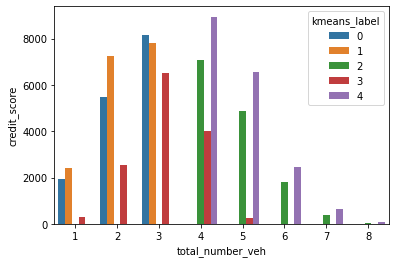

In [ ]:
kmeans_df_agg = kmeans_analysis.groupby(['kmeans_label', 'total_number_veh'], as_index=False).count()
sns.barplot(
    data=kmeans_df_agg, x='total_number_veh', y='credit_score',
    hue='kmeans_label'
)
plt.show()

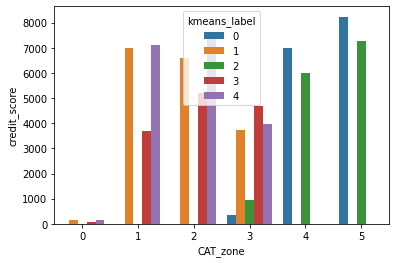

In [ ]:
kmeans_df_agg = kmeans_analysis.groupby(['kmeans_label', 'CAT_zone'], as_index=False).count()
sns.barplot(
    data=kmeans_df_agg, x='CAT_zone', y='credit_score',
    hue='kmeans_label'
)
plt.show()

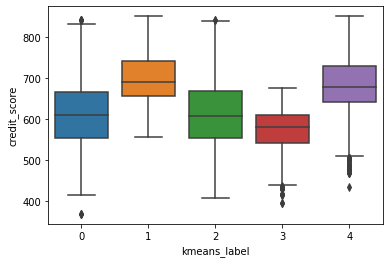

In [ ]:
sns.boxplot(
    data=kmeans_analysis, x='kmeans_label', y='credit_score'
)
plt.show()

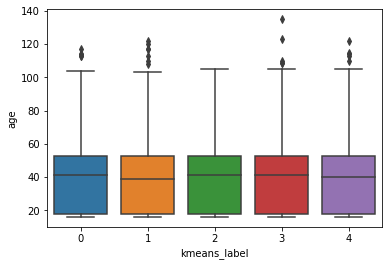

In [ ]:
sns.boxplot(
    data=kmeans_analysis, x='kmeans_label', y='age'
)
plt.show()

In [ ]:
kmeans_dummies = pd.get_dummies(kmeans_analysis.drop(['Quote_dt', 'zip', 'county_name', 'Agent_cd', 'policy_id'], axis=1))
kmeans_dummies.head()

CAT_zone  number_drivers  num_loaned_veh  num_owned_veh  num_leased_veh  \
0         2               2               1              2               0   
1         2               2               1              2               0   
3         2               2               1              2               1   
4         2               2               1              2               1   
6         4               2               0              1               2   

   total_number_veh  convert_ind  age  high_education_ind  dayofweek  month  \
0                 3            0   41                   1          2      1   
1                 3            0   58                   0          2      1   
3                 4            0   43                   1          0      9   
4                 4            0   55                   0          0      9   
6                 3            0   74                   1          2      5   

   quarter  quoted_amt  credit_score  safty_rating  kmeans_label  discount_No  \
0        1      5153.0         613.0          78.0             3            0   
1        1      5153.0         613.0          70.0             3            0   
3        3      3090.0         631.0          79.0             3            1   
4        3      3090.0         631.0          61.0             3            1   
6        2     14917.0         602.0          94.0             0            1   

   discount_Yes  Home_policy_ind_N  Home_policy_ind_Y  state_id_AL  \
0             1                  0                  1            0   
1             1                  0                  1            0   
3             0                  1                  0            0   
4             0                  1                  0            0   
6             0                  1                  0            0   

   state_id_CT  state_id_FL  state_id_GA  state_id_MN  state_id_NJ  \
0            0            0            0            0            0   
1            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
6            0            0            0            0            0   

   state_id_NY  state_id_WI  Prior_carrier_grp_Carrier_1  \
0            1            0                            1   
1            1            0                            1   
3            1            0                            0   
4            1            0                            0   
6            1            0                            0   

   Prior_carrier_grp_Carrier_2  Prior_carrier_grp_Carrier_3  \
0                            0                            0   
1                            0                            0   
3                            0                            0   
4                            0                            0   
6                            0                            1   

   Prior_carrier_grp_Carrier_4  Prior_carrier_grp_Carrier_5  \
0                            0                            0   
1                            0                            0   
3                            1                            0   
4                            1                            0   
6                            0                            0   

   Prior_carrier_grp_Carrier_6  Prior_carrier_grp_Carrier_7  \
0                            0                            0   
1                            0                            0   
3                            0                            0   
4                            0                            0   
6                            0                            0   

   Prior_carrier_grp_Carrier_8  Prior_carrier_grp_Missing  \
0                            0                          0   
1                            0                          0   
3                            0                   

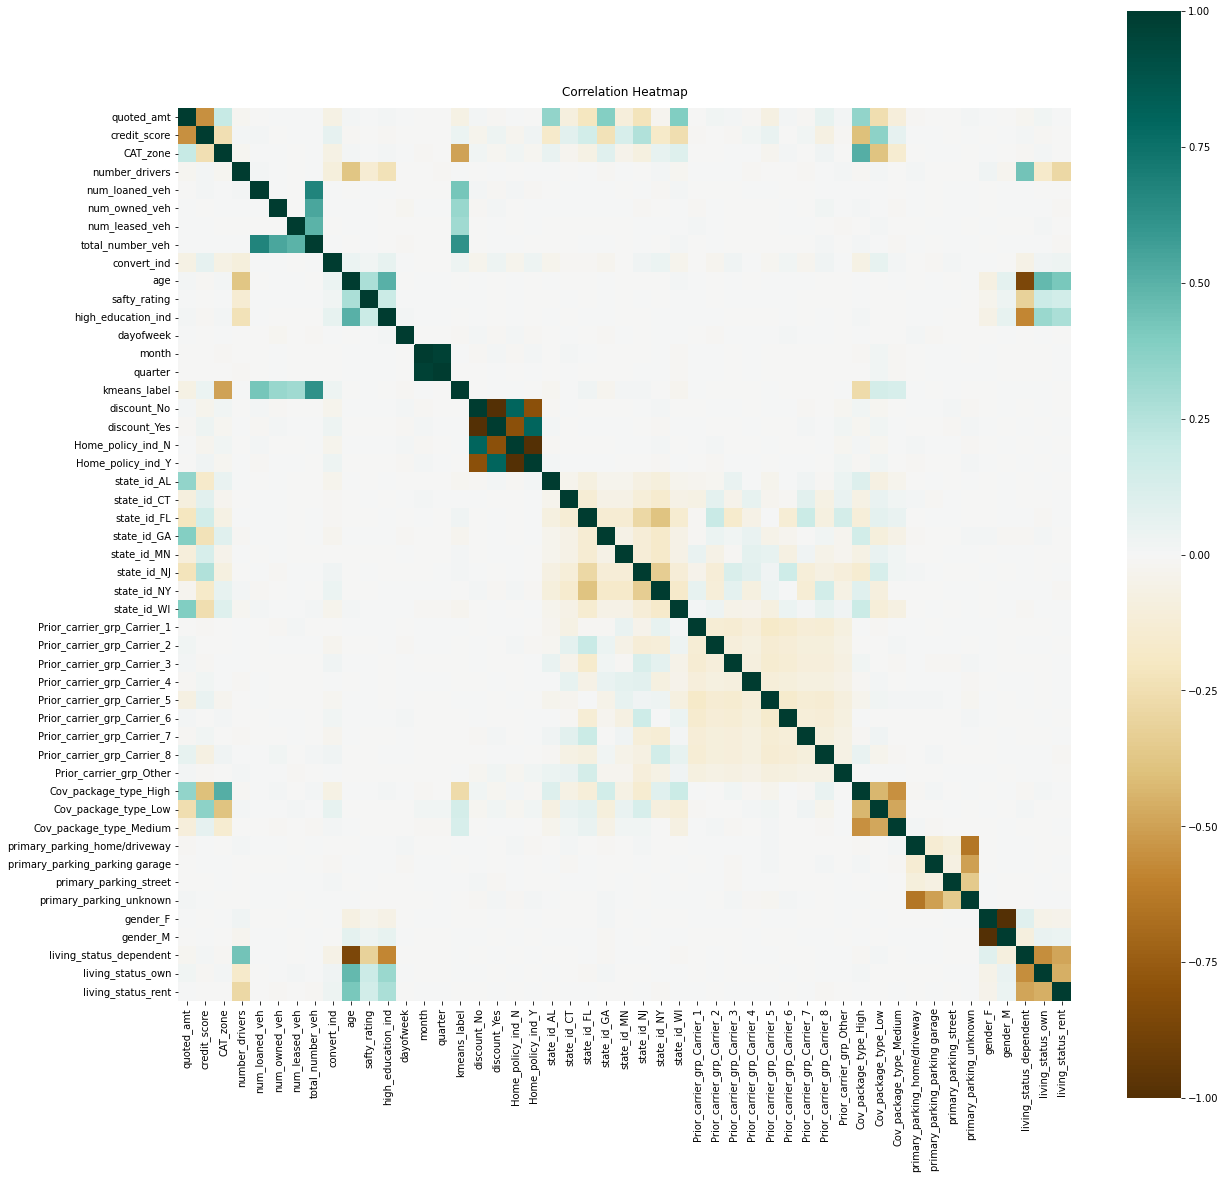

In [ ]:
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(
    kmeans_dummies.corr(method='pearson'), 
    annot=False, vmin=-1, vmax=1, square=True, 
    cmap="BrBG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

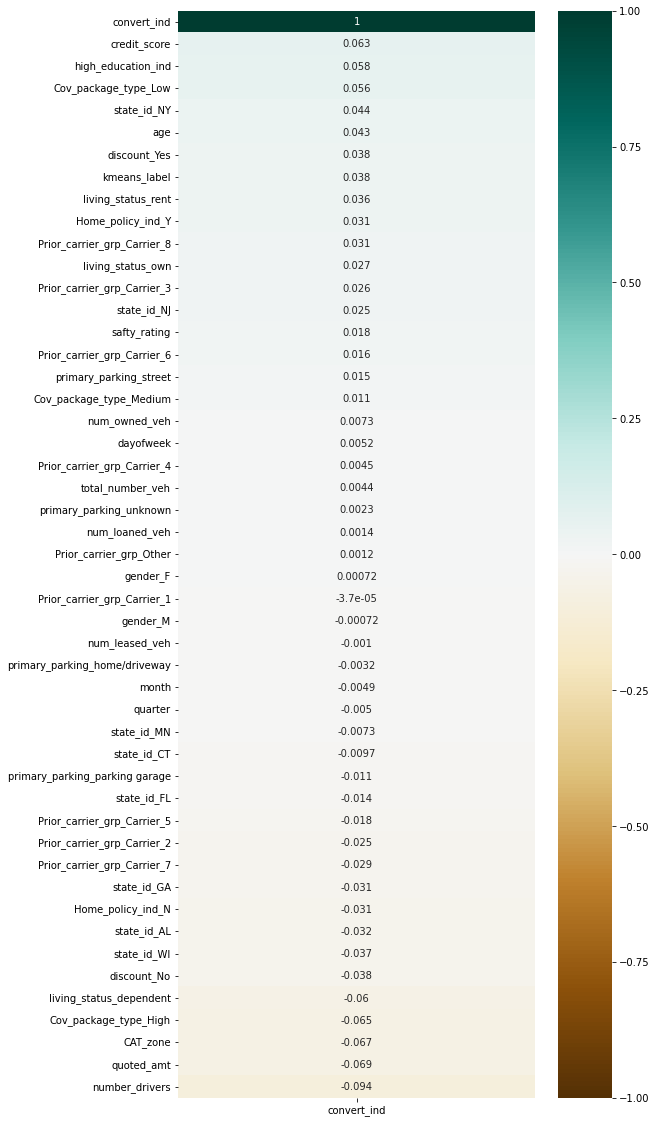

In [ ]:
plt.figure(figsize=(8,20))
fig = sns.heatmap(
    kmeans_dummies.corr()[['convert_ind']].sort_values(by='convert_ind', ascending = False), 
    vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

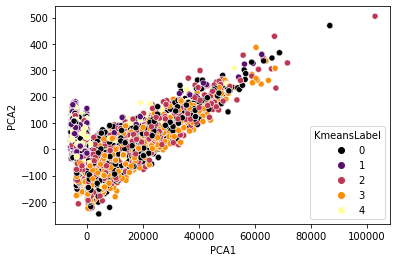

In [ ]:
pca_2d = PCA(n_components=2).fit_transform(kmeans_dummies)
pca_2d = pd.DataFrame(pca_2d).rename(columns={0:'PCA1', 1:"PCA2"})
pca_2d['KmeansLabel'] = kmeans.labels_
sns.scatterplot(
    data=pca_2d, x='PCA1', y='PCA2',
    hue='KmeansLabel', palette='inferno')
plt.show()

In [ ]:
pca_2d.sort_values('PCA1')

PCA1        PCA2  KmeansLabel
53693   -5784.094086   10.948260            1
53692   -5784.092813   10.925303            1
53691   -5784.092460   10.924178            1
70386   -5765.380842   56.024776            4
52854   -5758.420570   62.099126            4
...              ...         ...          ...
70328   71559.465508  327.844843            2
10603   86670.865023  469.794576            0
10601   86670.865897  469.758184            0
10602   86670.866094  469.735415            0
38583  102807.969802  505.232042            2

[79615 rows x 3 columns]

## NY

In [ ]:
df = load_df(train_test_split=False)
df = df.drop(['split'], axis=1)
df.head()

Quote_dt discount Home_policy_ind    zip state_id county_name  Agent_cd  \
0 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
1 2015-01-28      Yes               Y  10465       NY       Bronx  15973623   
2 2015-02-12       No               N  12801       NY      Warren  46978147   
3 2018-09-03       No               N  11548       NY      Nassau  32759856   
4 2018-09-03       No               N  11548       NY      Nassau  32759856   

   quoted_amt Prior_carrier_grp  credit_score Cov_package_type  CAT_zone  \
0      5153.0         Carrier_1         613.0             High         2   
1      5153.0         Carrier_1         613.0             High         2   
2      9870.0         Carrier_4         576.0              Low         4   
3      3090.0         Carrier_4         631.0           Medium         2   
4      3090.0         Carrier_4         631.0           Medium         2   

      policy_id  number_drivers  num_loaned_veh  num_owned_veh  \
0  policy_87209               2               1              2   
1  policy_87209               2               1              2   
2  policy_89288               1               1              1   
3  policy_91413               2               1              2   
4  policy_91413               2               1              2   

   num_leased_veh  total_number_veh  convert_ind primary_parking gender  \
0               0                 3          0.0   home/driveway      F   
1               0                 3          0.0   home/driveway      M   
2               2                 4          NaN         unknown      M   
3               1                 4          0.0         unknown      F   
4               1                 4          0.0         unknown      M   

  living_status  age  safty_rating  high_education_ind  dayofweek  month  \
0          rent   41          78.0                   1          2      1   
1          rent   58          70.0                   0          2      1   
2          rent   56          62.0                   1          3      2   
3          rent   43          79.0                   1          0      9   
4          rent   55          61.0                   0          0      9   

   quarter  
0        1  
1        1  
2        1  
3        3  
4        3

In [ ]:
ny = df.query('state_id=="NY" and county_name in ["New York", "Kings", "Queens", "Nassau"]')
ny.head()

Quote_dt discount Home_policy_ind    zip state_id county_name  Agent_cd  \
3  2018-09-03       No               N  11548       NY      Nassau  32759856   
4  2018-09-03       No               N  11548       NY      Nassau  32759856   
20 2017-08-01       No               N  11550       NY      Nassau  33958256   
31 2018-04-02       No               N  11419       NY      Queens  75584996   
32 2018-04-02       No               N  11419       NY      Queens  75584996   

    quoted_amt Prior_carrier_grp  credit_score Cov_package_type  CAT_zone  \
3       3090.0         Carrier_4         631.0           Medium         2   
4       3090.0         Carrier_4         631.0           Medium         2   
20      5829.0         Carrier_1         680.0              Low         1   
31      4660.0         Carrier_2         615.0              Low         1   
32      4660.0         Carrier_2         615.0              Low         1   

       policy_id  number_drivers  num_loaned_veh  num_owned_veh  \
3   policy_91413               2               1              2   
4   policy_91413               2               1              2   
20  policy_65525               1               2              3   
31  policy_86829               3               3              1   
32  policy_86829               3               3              1   

    num_leased_veh  total_number_veh  convert_ind primary_parking gender  \
3                1                 4          0.0         unknown      F   
4                1                 4          0.0         unknown      M   
20               0                 5          NaN         unknown      F   
31               0                 4          NaN  parking garage      M   
32               0                 4          NaN  parking garage      F   

   living_status  age  safty_rating  high_education_ind  dayofweek  month  \
3           rent   43          79.0                   1          0      9   
4           rent   55          61.0                   0          0      9   
20           own   55          72.0                   0          1      8   
31          rent   41          79.0                   1          0      4   
32          rent   46          81.0                   0          0      4   

    quarter  
3         3  
4         3  
20        3  
31        2  
32        2

In [ ]:
def plot_bar(var):
    pass

In [ ]:
living_NY = ny.groupby('living_status', as_index=False).count()[['living_status','policy_id']]
living_NY

living_status  policy_id
0     dependent       5847
1           own       5266
2          rent       4504

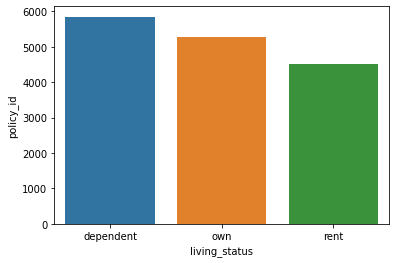

In [ ]:
sns.barplot(
    data=living_NY,
    x='living_status',
    y='policy_id'
)
plt.show()

# Sales

In [ ]:
policy = train.groupby('policy_id', as_index= False).first()
policy['Agent_cd'] = policy['Agent_cd'].astype('Int64').astype('object')  # convert type to object
policy.head(3)

policy_id   Quote_dt discount Home_policy_ind      zip state_id  \
0    policy_100 2017-06-11       No               N  35209.0       AL   
1   policy_1000 2018-03-24       No               N  35064.0       AL   
2  policy_10002 2018-07-04       No               N  32206.0       FL   

  county_name  Agent_cd  quoted_amt Prior_carrier_grp  credit_score  \
0   Jefferson  57246922     10698.0         Carrier_3         582.0   
1   Jefferson  89956217     43811.0         Carrier_3         560.0   
2       Duval  58906466      6624.0         Carrier_7         557.0   

  Cov_package_type  CAT_zone  number_drivers  num_loaned_veh  num_owned_veh  \
0             High         3               2               0              1   
1             High         5               1               2              1   
2             High         2               5               1              2   

   num_leased_veh  total_number_veh  convert_ind primary_parking gender  \
0               0                 1            0   home/driveway      F   
1               0                 3            0          street      M   
2               0                 3            0         unknown      M   

  living_status  age  safty_rating  high_education_ind  dayofweek  month  \
0           own   50          75.0                   1          6      6   
1          rent   35          50.0                   1          5      3   
2          rent   49          90.0                   1          2      7   

   quarter  
0        2  
1        1  
2        3

In [ ]:
revenue_df = policy.assign(
    revenue = lambda x: x['quoted_amt']*x['convert_ind']
).groupby('state_id', as_index=False).sum()[['state_id', 'revenue']]
revenue_df

state_id    revenue
0       AL   576009.0
1       CT   542811.0
2       FL  2957444.0
3       GA  1893315.0
4       MN   526159.0
5       NJ  2301763.0
6       NY  7338771.0
7       WI  1921135.0

In [ ]:
fig = px.choropleth(
    locations=revenue_df.state_id.tolist(), 
    locationmode="USA-states", scope="usa",
    color=revenue_df.revenue.tolist(),
    color_continuous_scale='ice')
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties["features"][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]},
 'id': '01001'}

In [ ]:
county_fips = {}
for i, geoinfo in enumerate(counties["features"]):
    county_fips[geoinfo['properties']['NAME']] = geoinfo['id']
county_fips

In [ ]:
revenue_df2 = pd.merge(
    policy.groupby('county_name', as_index=False).first()[['state_id','county_name']],
    policy.assign(
        revenue = lambda x: x['quoted_amt']*x['convert_ind']
        ).groupby('county_name', as_index=False).sum().assign(
            fips = lambda x: x['county_name'].map(county_fips)
            )[['county_name', 'fips', 'revenue']],
    on='county_name'
    )
revenue_df2

state_id  county_name   fips   revenue
0         FL      Alachua  12001   33004.0
1         NY       Albany  56001  170815.0
2         NY     Allegany  36003   27835.0
3         MN        Anoka  27003   24923.0
4         NJ     Atlantic  34001   27834.0
..       ...          ...    ...       ...
107       WI     Waukesha  55133   94188.0
108       WI      Waupaca  55135   18415.0
109       NY  Westchester  36119  589744.0
110       CT      Windham  50025   12367.0
111       WI    Winnebago  17201   81923.0

[112 rows x 4 columns]

In [ ]:
revenue_df2.query('fips=="36003"')

state_id county_name   fips  revenue
2       NY    Allegany  36003  27835.0

In [ ]:
fig = px.choropleth(
    revenue_df2, geojson=counties, locations='fips', 
    color='revenue', color_continuous_scale="ice",
    hover_data=['state_id','county_name'],
    scope="usa")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Sales Agent

In [ ]:
agent_df = policy.assign(
    revenue=lambda x: x['quoted_amt']*x['convert_ind']
)[['Agent_cd', 'revenue']].groupby('Agent_cd', as_index=False).sum()
agent_df['Agent_cd'] = agent_df['Agent_cd'].apply(str)
agent_df = agent_df.sort_values('revenue', ascending=False)
agent_df.head()

Agent_cd   revenue
387   32759856  156432.0
1395  86979213  118084.0
1427  88782607  116534.0
418   33958256  116111.0
121   18772661  112852.0